# About this notebook

## Version 1
- PyTorch Resnet50d starter code
- 5 folds
- 25 epochs
- batch size 64 no accumulation

## Version 2
- PyTorch Resnet50d starter code
- 5 folds
- 25 epochs
- batch size 64 accumulation_step = 2

## Version 3
- PyTorch Resnet50d starter code
- 5 folds
- 40 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart

## Version 4
- PyTorch Resnet50d starter code
- 5 folds
- 40 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart
- Add AutoAugment to image

## Version 5
- PyTorch Resnet50d starter code
- 5 folds
- 40 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart
- Add AutoAugment to image

## Version 6
- PyTorch Resnet50d starter code
- 5 folds
- 40 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart
- AdaptiveAvgPooling (GAP)

## Version 7
- PyTorch Resnet50d starter code
- 5 folds
- 40 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart
- AdaptiveAvgPooling (GAP) + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss

## Version 8
- PyTorch Resnet50d starter code
- 5 folds
- 60 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP)
- Arcface Loss + CrossEntropy Loss

## Version 9
- PyTorch Resnet50d starter code
- 5 folds
- 60 epochs
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP) + + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss

## Version 10
- PyTorch Resnet50d starter code
- Batch_size = 128
- 5 folds
- 60 epochs
- Image_size = 128
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP) + + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss

## Version 11
- PyTorch Resnet50d starter code
- Batch_size = 64
- 5 folds
- 60 epochs
- Image_size = 256
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP) + + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss
- Gradient Accumulation step = 2

## Version 12
- PyTorch Resnet50d starter code
- Batch_size = 64
- 5 folds
- 80 epochs
- Image_size = 256
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP) + + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss
- Gradient Accumulation step = 1
- Learning_rate = 1e-3 and eta_min = 1e-4*0.5

## Version 13
- PyTorch Resnet50d starter code
- Batch_size = 64
- 5 folds
- 100 epochs
- Image_size = 256
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 7
- AdaptiveAvgPooling (GAP) + + BNN (Batch Normalization Neck)
- Arcface Loss + CrossEntropy Loss
- Gradient Accumulation step = 1
- Learning_rate = 1e-3 and eta_min = 1e-4*0.5
- AdamW optimizer

## Version 14
- PyTorch Resnet50d starter code
- Batch_size = 64
- 5 folds
- 100 epochs
- Image_size = 256
- Data augmentation no cutmix, brightness, hueSaturation
- Cosineanealing scheduler no warmrestart T_max = 10
- AdaptiveAvgPooling (GAP)
- CrossEntropy Loss
- Gradient Accumulation step = 1
- Learning_rate = 1e-3 and eta_min = 1e-4*0.5

# Improvements maybe
- Add triplet loss with cross entropy for score improvement

# acknowledgement
- Y.NAKAMA great [notebook](https://www.kaggle.com/yasufuminakama/herbarium-2020-pytorch-resnet18-train/notebook)

If this notebook is helpful, feel free to upvote :)

In [1]:
!pip install -q --upgrade wandb
!pip install -q ttach
!pip install  timm
!pip install git+https://github.com/mapillary/inplace_abn.git@v1.0.12

     |████████████████████████████████| 512 kB 884 kB/s            
  Cloning https://github.com/mapillary/inplace_abn.git (to revision v1.0.12) to /tmp/pip-req-build-dhsq40al
  Running command git clone --filter=blob:none -q https://github.com/mapillary/inplace_abn.git /tmp/pip-req-build-dhsq40al
  Running command git checkout -q 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Resolved https://github.com/mapillary/inplace_abn.git to commit 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Preparing metadata (setup.py) ... - done
  Created wheel for inplace-abn: filename=inplace_abn-1.0.12-cp37-cp37m-linux_x86_64.whl size=3843272 sha256=c71b366f27276cfafc6da2f880b2f09e5dc16972bf6083ba2f80175bcd8e393c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fk1lroa6/wheels/df/ad/aa/7ec1eff8c9b56fb3fab10471e91c80bdf3b52036bf47727bae
Successfully built inplace-abn


# Data Loading

In [2]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 300

In [3]:
train = pd.read_csv('../input/microsoft-rice-disease-classification-challenge/Train.csv')
test = pd.read_csv('../input/microsoft-rice-disease-classification-challenge/Test.csv')
submission = pd.read_csv('../input/microsoft-rice-disease-classification-challenge/SampleSubmission.csv')

def get_path(image_id):
    return f"../input/microsoft-rice-disease-classification-challenge/Images/{image_id}"

train["image_paths"] = train["Image_id"].apply(get_path)

# remove RGN images
train.drop(train[train.index %2 != 0].index, inplace=True)
train = train.reset_index(drop=True)

In [4]:
train

,Image_id,Label,image_paths
0,id_004wknd7qd.jpg,blast,../input/microsoft-rice-disease-classification...
1,id_005sitfgr2.jpg,brown,../input/microsoft-rice-disease-classification...
2,id_00stp9t6m6.jpg,blast,../input/microsoft-rice-disease-classification...
3,id_012zxewnhx.jpg,blast,../input/microsoft-rice-disease-classification...
4,id_0186qwq2at.jpg,healthy,../input/microsoft-rice-disease-classification...
...,...,...,...
2665,id_zydzdp046u.jpg,healthy,../input/microsoft-rice-disease-classification...
2666,id_zyoowbqcm3.jpg,healthy,../input/microsoft-rice-disease-classification...
2667,id_zz6gzk7p97.jpg,brown,../input/microsoft-rice-disease-classification...
2668,id_zz8ca2p67e.jpg,blast,../input/microsoft-rice-disease-classification...


In [5]:
train["Label"].value_counts()

blast      1494
brown       766
healthy     410
Name: Label, dtype: int64

# Quick EDA

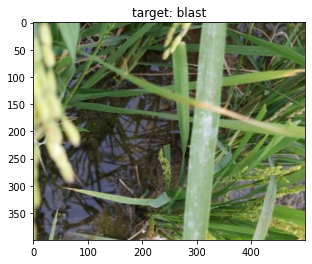

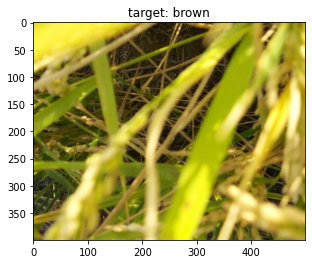

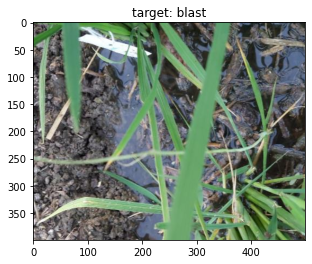

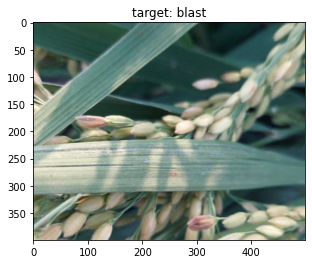

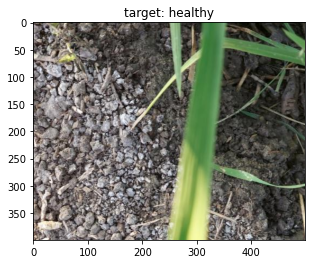

In [6]:
for i in range(5):
    image = cv.imread(train.loc[i, 'image_paths'])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    target = train.loc[i, 'Label']
    plt.imshow(image)
    plt.title(f"target: {target}")
    plt.show()

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train['Label'])
train['Label'] = le.transform(train['Label'])

# Directory settings

In [8]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [9]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=256
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=100
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':10,
        'eta_min':1e-4*0.5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.1,
        'patience':6,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    # OneCycleLR params
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e1,
        'max_lr':1e-3,
        'steps_per_epoch':3, 
        'epochs':3
    }
    batch_size=64
    momentum=0.9
    lr=1e-3
    weight_decay=1e-4
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=len(le.classes_)
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    model_name='resnet50d'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'resnet50d'
    preds_col = ["blast", "brown", "healthy"]
    train=True
    early_stop=True
    target_col="Label"
    scale=30.0
    margin=0.50
    easy_margin=False
    ls_eps=0.0
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


import albumentations as A
from torchvision import transforms ,datasets
from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VERSION = 14

# W&B

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Microsoft Rice Competition", 
                 name=f"{CFG.model_name} batch size",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe. Use `wandb login --relogin` to force relogin


# Utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = log_loss(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV schem

In [13]:
%%time
skf = StratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, vld_idx) in enumerate(skf.split(train, train[CFG.target_col])):
    train.loc[vld_idx, "folds"] = int(fold)
train["folds"] = train["folds"].astype(int)

CPU times: user 6.62 ms, sys: 2.12 ms, total: 8.74 ms
Wall time: 12.1 ms


# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_paths'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        try:
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = Image.open(file_path)
            image = image.convert("RGB")
            image = np.array(image)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [15]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose(
        [
           A.Resize(CFG.size, CFG.size),
           A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.Flip(p=0.5),
            
            #A.Cutout(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.5),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            #A.HueSaturationValue(
                #hue_shift_limit=0.2, sat_shift_limit=0.4,
                #val_shift_limit=0.2, p=0.5
            #),
            #A.RandomBrightnessContrast(
                #brightness_limit=(-0.1, 0.1),
                #contrast_limit=(-0.1, 0.1), p=0.5
            #),
            ToTensorV2(p=1.0),
        ]
    )

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

images.shape: torch.Size([64, 3, 256, 256])


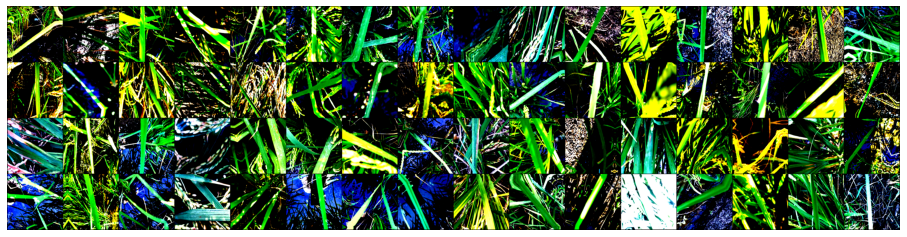

In [16]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

image_loader = DataLoader(train_dataset, 
                          batch_size  = 64, 
                          shuffle     = True, 
                          num_workers = 3,
                          pin_memory  = True)

for images, _ in image_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Model

In [17]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        
        if cfg.model_name in ['tf_efficientnetv2_b0', 'tf_efficientnet_b5', 'tf_efficientnet_b2']:
            self.in_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
            self.model.global_pool = nn.Identity()
            
        if cfg.model_name in ['resnext50_32x4d', 'resnet50d', 'resnet34d']:
            self.in_features = self.model.fc.in_features
            #self.model.fc = nn.Linear(self.in_features, self.cfg.fc_dim)
            self.model.fc = nn.Identity()
            self.model.global_pool = nn.Identity()
            
        if cfg.model_name == 'tresnet_m':
            self.in_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(self.in_features, self.cfg.fc_dim)
            
        elif cfg.model_name.split('_')[0] == 'vit':
            self.in_features = self.model.head.in_features
            self.model.head = nn.Linear(self.in_features, self.cfg.fc_dim)
        
        
        #self.pooling = GeM()
        self.pooling =  nn.AdaptiveAvgPool2d(1) # GAP
        self.probs = nn.Linear(self.in_features, self.cfg.target_size)
        self.bn = nn.BatchNorm1d(self.in_features) # BNNeck
        #self.final = ArcMarginProduct(
            #self.in_features,
            #cfg.target_size,
            #scale = cfg.scale,
            #margin = cfg.margin,
            #easy_margin = False,
            #ls_eps = 0.0
        #)

    def forward(self, x):
        batch_size = x.shape[0]
        # model backbone shape: torch.Size([4, 2048, 8, 8])
        features = self.model(x)
        # gap shape: torch.Size([4, 2048])
        features = self.pooling(features).view(batch_size, -1)
        #arcface = self.final(features, label)
        #bn = self.bn(features)
        probs   = self.probs(features)
        return probs

# Helper functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [20]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['folds'] != fold].index
    val_idx = folds[folds['folds'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds["Label"].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        
        #preds_label = np.argmax(preds, axis=1)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

            
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_loss': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
        
        
   
    valid_folds[CFG.preds_col] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds_loss']
   

    return valid_folds

In [21]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds_loss = result_df[CFG.preds_col].values
        labels = result_df["Label"].values
        score_loss = get_score(labels, preds_loss)
        LOGGER.info(f'Score with best loss weights: {score_loss:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df[['Image_id', 'blast', 'brown', 'healthy']].to_csv(OUTPUT_DIR+f'{CFG.model_name}_oof_rgb_df_version{VERSION}.csv', index=False)
        
    wandb.finish()

In [22]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


Epoch: [1][0/33] Elapsed 0m 9s (remain 4m 48s) Loss: 1.1092(1.1092) Grad: 2.7423 LR: 0.001000  
Epoch: [1][32/33] Elapsed 0m 27s (remain 0m 0s) Loss: 0.3869(0.6350) Grad: 2.1223 LR: 0.001000  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.9209(0.9209) 


Epoch 1 - avg_train_loss: 0.6350  avg_val_loss: 0.9964  time: 32s
Epoch 1 - Score: 0.9964
Epoch 1 - Save Best Loss: 0.9964 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7866(0.9964) 
Epoch: [2][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.4063(0.4063) Grad: 2.0894 LR: 0.000954  
Epoch: [2][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4792(0.4219) Grad: 1.5186 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.5012(0.5012) 


Epoch 2 - avg_train_loss: 0.4219  avg_val_loss: 0.4264  time: 23s
Epoch 2 - Score: 0.4264
Epoch 2 - Save Best Loss: 0.4264 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4242(0.4264) 
Epoch: [3][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.2003(0.2003) Grad: 0.8028 LR: 0.000847  
Epoch: [3][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3274(0.3450) Grad: 1.4367 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3963(0.3963) 


Epoch 3 - avg_train_loss: 0.3450  avg_val_loss: 0.4200  time: 23s
Epoch 3 - Score: 0.4200
Epoch 3 - Save Best Loss: 0.4200 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0336(0.4200) 
Epoch: [4][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2497(0.2497) Grad: 1.0334 LR: 0.000712  
Epoch: [4][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2616(0.2370) Grad: 1.2078 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.4825(0.4825) 


Epoch 4 - avg_train_loss: 0.2370  avg_val_loss: 0.3757  time: 23s
Epoch 4 - Score: 0.3757
Epoch 4 - Save Best Loss: 0.3757 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2632(0.3757) 
Epoch: [5][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0834(0.0834) Grad: 0.6556 LR: 0.000563  
Epoch: [5][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3340(0.2069) Grad: 1.6157 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3742(0.3742) 


Epoch 5 - avg_train_loss: 0.2069  avg_val_loss: 0.2385  time: 23s
Epoch 5 - Score: 0.2385
Epoch 5 - Save Best Loss: 0.2385 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3535(0.2385) 
Epoch: [6][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1951(0.1951) Grad: 0.9981 LR: 0.000413  
Epoch: [6][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1619(0.1585) Grad: 1.0354 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2432(0.2432) 


Epoch 6 - avg_train_loss: 0.1585  avg_val_loss: 0.1895  time: 23s
Epoch 6 - Score: 0.1895
Epoch 6 - Save Best Loss: 0.1895 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6463(0.1895) 
Epoch: [7][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.1231(0.1231) Grad: 0.9764 LR: 0.000277  
Epoch: [7][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0872(0.1109) Grad: 0.6555 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3139(0.3139) 


Epoch 7 - avg_train_loss: 0.1109  avg_val_loss: 0.1758  time: 23s
Epoch 7 - Score: 0.1758
Epoch 7 - Save Best Loss: 0.1758 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6526(0.1758) 
Epoch: [8][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0624(0.0624) Grad: 0.5590 LR: 0.000167  
Epoch: [8][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0378(0.0856) Grad: 0.4997 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1874(0.1874) 


Epoch 8 - avg_train_loss: 0.0856  avg_val_loss: 0.1525  time: 23s
Epoch 8 - Score: 0.1525
Epoch 8 - Save Best Loss: 0.1525 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6532(0.1525) 
Epoch: [9][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0202(0.0202) Grad: 0.2812 LR: 0.000092  
Epoch: [9][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0153(0.0654) Grad: 0.2353 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2608(0.2608) 


Epoch 9 - avg_train_loss: 0.0654  avg_val_loss: 0.1455  time: 23s
Epoch 9 - Score: 0.1455
Epoch 9 - Save Best Loss: 0.1455 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4710(0.1455) 
Epoch: [10][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0268(0.0268) Grad: 0.4359 LR: 0.000056  
Epoch: [10][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0210(0.0588) Grad: 0.3675 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2398(0.2398) 


Epoch 10 - avg_train_loss: 0.0588  avg_val_loss: 0.1440  time: 23s
Epoch 10 - Score: 0.1440
Epoch 10 - Save Best Loss: 0.1440 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5988(0.1440) 
Epoch: [11][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0243(0.0243) Grad: 0.3216 LR: 0.000050  
Epoch: [11][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0390(0.0407) Grad: 0.4369 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2154(0.2154) 


Epoch 11 - avg_train_loss: 0.0407  avg_val_loss: 0.1318  time: 23s
Epoch 11 - Score: 0.1318
Epoch 11 - Save Best Loss: 0.1318 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5241(0.1318) 
Epoch: [12][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0360(0.0360) Grad: 0.3968 LR: 0.000096  
Epoch: [12][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1271(0.0480) Grad: 1.3874 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2339(0.2339) 


Epoch 12 - avg_train_loss: 0.0480  avg_val_loss: 0.1485  time: 23s
Epoch 12 - Score: 0.1485


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4875(0.1485) 
Epoch: [13][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0459(0.0459) Grad: 0.8573 LR: 0.000404  
Epoch: [13][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0228(0.0374) Grad: 0.3875 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2726(0.2726) 


Epoch 13 - avg_train_loss: 0.0374  avg_val_loss: 0.1544  time: 23s
Epoch 13 - Score: 0.1544


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5990(0.1544) 
Epoch: [14][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0847(0.0847) Grad: 0.6688 LR: 0.000473  
Epoch: [14][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0367(0.0508) Grad: 0.5328 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2066(0.2066) 


Epoch 14 - avg_train_loss: 0.0508  avg_val_loss: 0.1555  time: 23s
Epoch 14 - Score: 0.1555


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4445(0.1555) 
Epoch: [15][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1032(0.1032) Grad: 1.3937 LR: 0.000600  
Epoch: [15][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.3790(0.0832) Grad: 2.8153 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4652(0.4652) 


Epoch 15 - avg_train_loss: 0.0832  avg_val_loss: 0.2932  time: 23s
Epoch 15 - Score: 0.2932


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0724(0.2932) 
Epoch: [16][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1586(0.1586) Grad: 1.5614 LR: 0.000737  
Epoch: [16][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2029(0.1500) Grad: 2.0197 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1892(0.1892) 


Epoch 16 - avg_train_loss: 0.1500  avg_val_loss: 0.2601  time: 23s
Epoch 16 - Score: 0.2601


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6286(0.2601) 
Epoch: [17][0/33] Elapsed 0m 1s (remain 0m 57s) Loss: 0.1027(0.1027) Grad: 0.7952 LR: 0.000864  
Epoch: [17][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.2562(0.1137) Grad: 1.3562 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3449(0.3449) 


Epoch 17 - avg_train_loss: 0.1137  avg_val_loss: 0.3013  time: 23s
Epoch 17 - Score: 0.3013


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9415(0.3013) 
Epoch: [18][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0690(0.0690) Grad: 1.1585 LR: 0.000965  
Epoch: [18][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.3476(0.1961) Grad: 1.7415 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3634(0.3634) 


Epoch 18 - avg_train_loss: 0.1961  avg_val_loss: 0.3292  time: 23s
Epoch 18 - Score: 0.3292


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4723(0.3292) 
Epoch: [19][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.1791(0.1791) Grad: 0.8497 LR: 0.001029  
Epoch: [19][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0990(0.2196) Grad: 0.5484 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2151(0.2151) 


Epoch 19 - avg_train_loss: 0.2196  avg_val_loss: 0.2333  time: 23s
Epoch 19 - Score: 0.2333


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6109(0.2333) 
Epoch: [20][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0652(0.0652) Grad: 0.5751 LR: 0.001050  
Epoch: [20][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1617(0.1832) Grad: 0.8794 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2309(0.2309) 


Epoch 20 - avg_train_loss: 0.1832  avg_val_loss: 0.2167  time: 23s
Epoch 20 - Score: 0.2167


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1476(0.2167) 
Epoch: [21][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.1403(0.1403) Grad: 0.8061 LR: 0.001024  
Epoch: [21][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2021(0.1267) Grad: 1.4256 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3701(0.3701) 


Epoch 21 - avg_train_loss: 0.1267  avg_val_loss: 0.2984  time: 23s
Epoch 21 - Score: 0.2984


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3225(0.2984) 
Epoch: [22][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0288(0.0288) Grad: 0.3572 LR: 0.000954  
Epoch: [22][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.1194(0.1208) Grad: 0.8735 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3124(0.3124) 


Epoch 22 - avg_train_loss: 0.1208  avg_val_loss: 0.3243  time: 24s
Epoch 22 - Score: 0.3243


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2873(0.3243) 
Epoch: [23][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1613(0.1613) Grad: 0.8746 LR: 0.000847  
Epoch: [23][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1203(0.0952) Grad: 1.0634 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1375(0.1375) 


Epoch 23 - avg_train_loss: 0.0952  avg_val_loss: 0.2346  time: 23s
Epoch 23 - Score: 0.2346


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6770(0.2346) 
Epoch: [24][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0555(0.0555) Grad: 0.7130 LR: 0.000712  
Epoch: [24][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1346(0.1453) Grad: 0.8931 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3225(0.3225) 


Epoch 24 - avg_train_loss: 0.1453  avg_val_loss: 0.2616  time: 23s
Epoch 24 - Score: 0.2616


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8084(0.2616) 
Epoch: [25][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1207(0.1207) Grad: 0.8392 LR: 0.000563  
Epoch: [25][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0736(0.0830) Grad: 0.6179 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1909(0.1909) 


Epoch 25 - avg_train_loss: 0.0830  avg_val_loss: 0.1607  time: 23s
Epoch 25 - Score: 0.1607


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2952(0.1607) 
Epoch: [26][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.2643(0.2643) Grad: 1.3815 LR: 0.000413  
Epoch: [26][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0538(0.0580) Grad: 0.6284 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3092(0.3092) 


Epoch 26 - avg_train_loss: 0.0580  avg_val_loss: 0.1533  time: 23s
Epoch 26 - Score: 0.1533


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5148(0.1533) 
Epoch: [27][0/33] Elapsed 0m 2s (remain 1m 7s) Loss: 0.0115(0.0115) Grad: 0.1991 LR: 0.000277  
Epoch: [27][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0135(0.0218) Grad: 0.2589 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3343(0.3343) 


Epoch 27 - avg_train_loss: 0.0218  avg_val_loss: 0.1472  time: 24s
Epoch 27 - Score: 0.1472


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4743(0.1472) 
Epoch: [28][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0165(0.0165) Grad: 0.4412 LR: 0.000167  
Epoch: [28][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0025(0.0265) Grad: 0.0520 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.4224(0.4224) 


Epoch 28 - avg_train_loss: 0.0265  avg_val_loss: 0.1617  time: 23s
Epoch 28 - Score: 0.1617


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5604(0.1617) 
Epoch: [29][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0055(0.0055) Grad: 0.1279 LR: 0.000092  
Epoch: [29][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0022(0.0200) Grad: 0.0294 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3377(0.3377) 


Epoch 29 - avg_train_loss: 0.0200  avg_val_loss: 0.1553  time: 23s
Epoch 29 - Score: 0.1553


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6237(0.1553) 
Epoch: [30][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0062(0.0062) Grad: 0.1208 LR: 0.000056  
Epoch: [30][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0064(0.0141) Grad: 0.1352 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3562(0.3562) 


Epoch 30 - avg_train_loss: 0.0141  avg_val_loss: 0.1488  time: 23s
Epoch 30 - Score: 0.1488


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5375(0.1488) 
Epoch: [31][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0320(0.0320) Grad: 0.4962 LR: 0.000050  
Epoch: [31][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0203(0.0150) Grad: 0.4510 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3798(0.3798) 


Epoch 31 - avg_train_loss: 0.0150  avg_val_loss: 0.1533  time: 23s
Epoch 31 - Score: 0.1533


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4620(0.1533) 
Epoch: [32][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0611(0.0611) Grad: 0.8701 LR: 0.000096  
Epoch: [32][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0044(0.0114) Grad: 0.0845 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.3622(0.3622) 


Epoch 32 - avg_train_loss: 0.0114  avg_val_loss: 0.1444  time: 23s
Epoch 32 - Score: 0.1444


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4515(0.1444) 
Epoch: [33][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0058(0.0058) Grad: 0.1793 LR: 0.000404  
Epoch: [33][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0023(0.0103) Grad: 0.0484 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4095(0.4095) 


Epoch 33 - avg_train_loss: 0.0103  avg_val_loss: 0.1463  time: 23s
Epoch 33 - Score: 0.1463


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4137(0.1463) 
Epoch: [34][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0027(0.0027) Grad: 0.0469 LR: 0.000473  
Epoch: [34][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0060(0.0111) Grad: 0.1804 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3522(0.3522) 


Epoch 34 - avg_train_loss: 0.0111  avg_val_loss: 0.1474  time: 23s
Epoch 34 - Score: 0.1474


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5559(0.1474) 
Epoch: [35][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0015(0.0015) Grad: 0.0387 LR: 0.000600  
Epoch: [35][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0083) Grad: 0.1389 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3958(0.3958) 


Epoch 35 - avg_train_loss: 0.0083  avg_val_loss: 0.1516  time: 23s
Epoch 35 - Score: 0.1516


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3835(0.1516) 
Epoch: [36][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0186(0.0186) Grad: 0.4372 LR: 0.000737  
Epoch: [36][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0372(0.0305) Grad: 0.9392 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3969(0.3969) 


Epoch 36 - avg_train_loss: 0.0305  avg_val_loss: 0.1911  time: 23s
Epoch 36 - Score: 0.1911


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7600(0.1911) 
Epoch: [37][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0197(0.0197) Grad: 0.6147 LR: 0.000864  
Epoch: [37][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0484(0.0633) Grad: 0.6052 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.5199(0.5199) 


Epoch 37 - avg_train_loss: 0.0633  avg_val_loss: 0.2139  time: 23s
Epoch 37 - Score: 0.2139


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9570(0.2139) 
Epoch: [38][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.2171(0.2171) Grad: 1.2422 LR: 0.000965  
Epoch: [38][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0760(0.1051) Grad: 0.6587 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.6937(0.6937) 


Epoch 38 - avg_train_loss: 0.1051  avg_val_loss: 0.4533  time: 23s
Epoch 38 - Score: 0.4533


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1028(0.4533) 
Epoch: [39][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.1470(0.1470) Grad: 1.1523 LR: 0.001029  
Epoch: [39][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1076(0.1358) Grad: 0.8286 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2092(0.2092) 


Epoch 39 - avg_train_loss: 0.1358  avg_val_loss: 0.3417  time: 23s
Epoch 39 - Score: 0.3417


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4754(0.3417) 
Epoch: [40][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1039(0.1039) Grad: 0.6526 LR: 0.001050  
Epoch: [40][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1663(0.1401) Grad: 1.4435 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.4128(0.4128) 


Epoch 40 - avg_train_loss: 0.1401  avg_val_loss: 0.2557  time: 23s
Epoch 40 - Score: 0.2557


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2445(0.2557) 
Epoch: [41][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0829(0.0829) Grad: 0.5760 LR: 0.001024  
Epoch: [41][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.2162(0.1436) Grad: 1.1685 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2005(0.2005) 


Epoch 41 - avg_train_loss: 0.1436  avg_val_loss: 0.2241  time: 24s
Epoch 41 - Score: 0.2241


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9942(0.2241) 
Epoch: [42][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0860(0.0860) Grad: 0.7227 LR: 0.000954  
Epoch: [42][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0523(0.0883) Grad: 0.5185 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3370(0.3370) 


Epoch 42 - avg_train_loss: 0.0883  avg_val_loss: 0.1741  time: 23s
Epoch 42 - Score: 0.1741


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4183(0.1741) 
Epoch: [43][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0282(0.0282) Grad: 0.3681 LR: 0.000847  
Epoch: [43][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1289(0.1065) Grad: 0.8992 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3035(0.3035) 


Epoch 43 - avg_train_loss: 0.1065  avg_val_loss: 0.1533  time: 23s
Epoch 43 - Score: 0.1533


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3793(0.1533) 
Epoch: [44][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.1100(0.1100) Grad: 1.1374 LR: 0.000712  
Epoch: [44][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0803(0.0677) Grad: 0.8312 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1878(0.1878) 


Epoch 44 - avg_train_loss: 0.0677  avg_val_loss: 0.1793  time: 23s
Epoch 44 - Score: 0.1793


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6488(0.1793) 
Epoch: [45][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0575(0.0575) Grad: 0.6535 LR: 0.000563  
Epoch: [45][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0265(0.0524) Grad: 0.4178 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.6200(0.6200) 


Epoch 45 - avg_train_loss: 0.0524  avg_val_loss: 0.4676  time: 23s
Epoch 45 - Score: 0.4676


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5949(0.4676) 
Epoch: [46][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0084(0.0084) Grad: 0.1282 LR: 0.000413  
Epoch: [46][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0060(0.0382) Grad: 0.0903 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2327(0.2327) 


Epoch 46 - avg_train_loss: 0.0382  avg_val_loss: 0.1221  time: 23s
Epoch 46 - Score: 0.1221
Epoch 46 - Save Best Loss: 0.1221 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4088(0.1221) 
Epoch: [47][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0410(0.0410) Grad: 0.6790 LR: 0.000277  
Epoch: [47][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0076(0.0289) Grad: 0.1928 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2593(0.2593) 


Epoch 47 - avg_train_loss: 0.0289  avg_val_loss: 0.1055  time: 23s
Epoch 47 - Score: 0.1055
Epoch 47 - Save Best Loss: 0.1055 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4644(0.1055) 
Epoch: [48][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0029(0.0029) Grad: 0.0504 LR: 0.000167  
Epoch: [48][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0509(0.0167) Grad: 1.1441 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2668(0.2668) 


Epoch 48 - avg_train_loss: 0.0167  avg_val_loss: 0.1030  time: 23s
Epoch 48 - Score: 0.1030
Epoch 48 - Save Best Loss: 0.1030 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5641(0.1030) 
Epoch: [49][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0101(0.0101) Grad: 0.1400 LR: 0.000092  
Epoch: [49][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0028(0.0142) Grad: 0.0889 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2795(0.2795) 


Epoch 49 - avg_train_loss: 0.0142  avg_val_loss: 0.1128  time: 23s
Epoch 49 - Score: 0.1128


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4785(0.1128) 
Epoch: [50][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0023(0.0023) Grad: 0.0533 LR: 0.000056  
Epoch: [50][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0021(0.0118) Grad: 0.0339 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2568(0.2568) 


Epoch 50 - avg_train_loss: 0.0118  avg_val_loss: 0.1128  time: 23s
Epoch 50 - Score: 0.1128


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5727(0.1128) 
Epoch: [51][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0080(0.0080) Grad: 0.1880 LR: 0.000050  
Epoch: [51][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0079(0.0098) Grad: 0.2395 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2589(0.2589) 


Epoch 51 - avg_train_loss: 0.0098  avg_val_loss: 0.1103  time: 23s
Epoch 51 - Score: 0.1103


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5571(0.1103) 
Epoch: [52][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0226(0.0226) Grad: 0.4350 LR: 0.000096  
Epoch: [52][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0392(0.0099) Grad: 0.8219 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2782(0.2782) 


Epoch 52 - avg_train_loss: 0.0099  avg_val_loss: 0.1131  time: 23s
Epoch 52 - Score: 0.1131


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5527(0.1131) 
Epoch: [53][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0017(0.0017) Grad: 0.0253 LR: 0.000404  
Epoch: [53][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0136(0.0067) Grad: 0.2911 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3028(0.3028) 


Epoch 53 - avg_train_loss: 0.0067  avg_val_loss: 0.1201  time: 23s
Epoch 53 - Score: 0.1201


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5083(0.1201) 
Epoch: [54][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0041(0.0041) Grad: 0.0936 LR: 0.000473  
Epoch: [54][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0028(0.0083) Grad: 0.0628 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3074(0.3074) 


Epoch 54 - avg_train_loss: 0.0083  avg_val_loss: 0.1165  time: 23s
Epoch 54 - Score: 0.1165


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5008(0.1165) 
Epoch: [55][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0026(0.0026) Grad: 0.0518 LR: 0.000600  
Epoch: [55][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0092(0.0132) Grad: 0.1877 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2628(0.2628) 


Epoch 55 - avg_train_loss: 0.0132  avg_val_loss: 0.1123  time: 23s
Epoch 55 - Score: 0.1123


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4371(0.1123) 
Epoch: [56][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0234(0.0234) Grad: 0.6058 LR: 0.000737  
Epoch: [56][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0020(0.0153) Grad: 0.0332 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2550(0.2550) 


Epoch 56 - avg_train_loss: 0.0153  avg_val_loss: 0.1640  time: 23s
Epoch 56 - Score: 0.1640


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7766(0.1640) 
Epoch: [57][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0010(0.0010) Grad: 0.0156 LR: 0.000864  
Epoch: [57][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0095(0.0198) Grad: 0.2322 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.4448(0.4448) 


Epoch 57 - avg_train_loss: 0.0198  avg_val_loss: 0.1579  time: 23s
Epoch 57 - Score: 0.1579


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5391(0.1579) 
Epoch: [58][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0098(0.0098) Grad: 0.2755 LR: 0.000965  
Epoch: [58][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0392(0.0566) Grad: 0.7935 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.4260(0.4260) 


Epoch 58 - avg_train_loss: 0.0566  avg_val_loss: 0.3342  time: 23s
Epoch 58 - Score: 0.3342


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8880(0.3342) 
Epoch: [59][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1216(0.1216) Grad: 1.1119 LR: 0.001029  
Epoch: [59][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1282(0.1359) Grad: 0.8649 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.7473(0.7473) 


Epoch 59 - avg_train_loss: 0.1359  avg_val_loss: 0.6298  time: 23s
Epoch 59 - Score: 0.6298


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.8009(0.6298) 
Epoch: [60][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2023(0.2023) Grad: 1.0634 LR: 0.001050  
Epoch: [60][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0388(0.1461) Grad: 0.3172 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2385(0.2385) 


Epoch 60 - avg_train_loss: 0.1461  avg_val_loss: 0.1866  time: 23s
Epoch 60 - Score: 0.1866


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8093(0.1866) 
Epoch: [61][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1142(0.1142) Grad: 0.6107 LR: 0.001024  
Epoch: [61][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0473(0.0857) Grad: 0.5710 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3682(0.3682) 


Epoch 61 - avg_train_loss: 0.0857  avg_val_loss: 0.2029  time: 23s
Epoch 61 - Score: 0.2029


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3623(0.2029) 
Epoch: [62][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0649(0.0649) Grad: 0.7477 LR: 0.000954  
Epoch: [62][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0479(0.0732) Grad: 0.5237 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.4615(0.4615) 


Epoch 62 - avg_train_loss: 0.0732  avg_val_loss: 0.3624  time: 23s
Epoch 62 - Score: 0.3624


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3782(0.3624) 
Epoch: [63][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0754(0.0754) Grad: 0.9945 LR: 0.000847  
Epoch: [63][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0999(0.0808) Grad: 0.9074 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2604(0.2604) 


Epoch 63 - avg_train_loss: 0.0808  avg_val_loss: 0.2508  time: 23s
Epoch 63 - Score: 0.2508


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6867(0.2508) 
Epoch: [64][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1157(0.1157) Grad: 0.8985 LR: 0.000712  
Epoch: [64][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1205(0.0559) Grad: 1.1790 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2399(0.2399) 


Epoch 64 - avg_train_loss: 0.0559  avg_val_loss: 0.1848  time: 23s
Epoch 64 - Score: 0.1848


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7732(0.1848) 
Epoch: [65][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0390(0.0390) Grad: 0.5071 LR: 0.000563  
Epoch: [65][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1116(0.0438) Grad: 1.0290 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1858(0.1858) 


Epoch 65 - avg_train_loss: 0.0438  avg_val_loss: 0.2103  time: 23s
Epoch 65 - Score: 0.2103


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7155(0.2103) 
Epoch: [66][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1133(0.1133) Grad: 0.7405 LR: 0.000413  
Epoch: [66][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0571(0.0386) Grad: 0.7837 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1616(0.1616) 


Epoch 66 - avg_train_loss: 0.0386  avg_val_loss: 0.1556  time: 23s
Epoch 66 - Score: 0.1556


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4006(0.1556) 
Epoch: [67][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0061(0.0061) Grad: 0.1017 LR: 0.000277  
Epoch: [67][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0017(0.0175) Grad: 0.0218 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2817(0.2817) 


Epoch 67 - avg_train_loss: 0.0175  avg_val_loss: 0.1533  time: 23s
Epoch 67 - Score: 0.1533


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0119(0.1533) 
Epoch: [68][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0024(0.0024) Grad: 0.0327 LR: 0.000167  
Epoch: [68][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0149(0.0144) Grad: 0.2450 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3368(0.3368) 


Epoch 68 - avg_train_loss: 0.0144  avg_val_loss: 0.1389  time: 23s
Epoch 68 - Score: 0.1389


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7211(0.1389) 
Epoch: [69][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0160(0.0160) Grad: 0.2510 LR: 0.000092  
Epoch: [69][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0075(0.0114) Grad: 0.1695 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.3171(0.3171) 


Epoch 69 - avg_train_loss: 0.0114  avg_val_loss: 0.1432  time: 23s
Epoch 69 - Score: 0.1432


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7326(0.1432) 
Epoch: [70][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0179(0.0179) Grad: 0.4101 LR: 0.000056  
Epoch: [70][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0035(0.0066) Grad: 0.0654 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3199(0.3199) 


Epoch 70 - avg_train_loss: 0.0066  avg_val_loss: 0.1422  time: 23s
Epoch 70 - Score: 0.1422


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7642(0.1422) 
Epoch: [71][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0180(0.0180) Grad: 0.5401 LR: 0.000050  
Epoch: [71][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0027(0.0102) Grad: 0.0432 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3506(0.3506) 


Epoch 71 - avg_train_loss: 0.0102  avg_val_loss: 0.1406  time: 23s
Epoch 71 - Score: 0.1406


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7079(0.1406) 
Epoch: [72][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0287(0.0287) Grad: 0.5491 LR: 0.000096  
Epoch: [72][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0014(0.0101) Grad: 0.0258 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3504(0.3504) 


Epoch 72 - avg_train_loss: 0.0101  avg_val_loss: 0.1370  time: 23s
Epoch 72 - Score: 0.1370


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6605(0.1370) 
Epoch: [73][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0061(0.0061) Grad: 0.1683 LR: 0.000404  
Epoch: [73][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0031(0.0054) Grad: 0.0712 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3307(0.3307) 


Epoch 73 - avg_train_loss: 0.0054  avg_val_loss: 0.1367  time: 23s
Epoch 73 - Score: 0.1367


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6912(0.1367) 
Epoch: [74][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0045(0.0045) Grad: 0.1198 LR: 0.000473  
Epoch: [74][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0024(0.0061) Grad: 0.0433 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2984(0.2984) 


Epoch 74 - avg_train_loss: 0.0061  avg_val_loss: 0.1416  time: 23s
Epoch 74 - Score: 0.1416


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8496(0.1416) 
Epoch: [75][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0062(0.0062) Grad: 0.1967 LR: 0.000600  
Epoch: [75][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0035(0.0067) Grad: 0.0797 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2446(0.2446) 


Epoch 75 - avg_train_loss: 0.0067  avg_val_loss: 0.1263  time: 23s
Epoch 75 - Score: 0.1263


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6528(0.1263) 
Epoch: [76][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0027(0.0027) Grad: 0.0667 LR: 0.000737  
Epoch: [76][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0386(0.0112) Grad: 0.5600 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3259(0.3259) 


Epoch 76 - avg_train_loss: 0.0112  avg_val_loss: 0.1431  time: 22s
Epoch 76 - Score: 0.1431


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6024(0.1431) 
Epoch: [77][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0010(0.0010) Grad: 0.0263 LR: 0.000864  
Epoch: [77][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0114(0.0280) Grad: 0.2646 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2390(0.2390) 


Epoch 77 - avg_train_loss: 0.0280  avg_val_loss: 0.1706  time: 23s
Epoch 77 - Score: 0.1706


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6969(0.1706) 
Epoch: [78][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1050(0.1050) Grad: 1.0310 LR: 0.000965  
Epoch: [78][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0368(0.0758) Grad: 0.4398 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2670(0.2670) 


Epoch 78 - avg_train_loss: 0.0758  avg_val_loss: 0.2021  time: 23s
Epoch 78 - Score: 0.2021


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7582(0.2021) 
Epoch: [79][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0436(0.0436) Grad: 0.4242 LR: 0.001029  
Epoch: [79][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0385(0.0701) Grad: 0.5098 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 13s) Loss: 0.2955(0.2955) 


Epoch 79 - avg_train_loss: 0.0701  avg_val_loss: 0.2116  time: 23s
Epoch 79 - Score: 0.2116


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4153(0.2116) 
Epoch: [80][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0468(0.0468) Grad: 0.4162 LR: 0.001050  
Epoch: [80][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0813(0.1049) Grad: 0.7035 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2676(0.2676) 


Epoch 80 - avg_train_loss: 0.1049  avg_val_loss: 0.2738  time: 23s
Epoch 80 - Score: 0.2738


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4600(0.2738) 
Epoch: [81][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0477(0.0477) Grad: 0.4480 LR: 0.001024  
Epoch: [81][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1382(0.1017) Grad: 0.8323 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3044(0.3044) 


Epoch 81 - avg_train_loss: 0.1017  avg_val_loss: 0.2324  time: 23s
Epoch 81 - Score: 0.2324


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2785(0.2324) 
Epoch: [82][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0714(0.0714) Grad: 0.3898 LR: 0.000954  
Epoch: [82][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0513(0.0923) Grad: 0.4765 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2115(0.2115) 


Epoch 82 - avg_train_loss: 0.0923  avg_val_loss: 0.1774  time: 23s
Epoch 82 - Score: 0.1774


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5143(0.1774) 
Epoch: [83][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0779(0.0779) Grad: 0.7238 LR: 0.000847  
Epoch: [83][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0678(0.0540) Grad: 0.6825 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2427(0.2427) 


Epoch 83 - avg_train_loss: 0.0540  avg_val_loss: 0.1434  time: 23s
Epoch 83 - Score: 0.1434


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3120(0.1434) 
Epoch: [84][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0258(0.0258) Grad: 0.2976 LR: 0.000712  
Epoch: [84][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0781(0.0494) Grad: 1.4029 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2239(0.2239) 


Epoch 84 - avg_train_loss: 0.0494  avg_val_loss: 0.1496  time: 23s
Epoch 84 - Score: 0.1496


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9036(0.1496) 
Epoch: [85][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0187(0.0187) Grad: 0.2501 LR: 0.000563  
Epoch: [85][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0262(0.0351) Grad: 0.2888 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2024(0.2024) 


Epoch 85 - avg_train_loss: 0.0351  avg_val_loss: 0.1364  time: 23s
Epoch 85 - Score: 0.1364


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5249(0.1364) 
Epoch: [86][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0090(0.0090) Grad: 0.1822 LR: 0.000413  
Epoch: [86][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0816(0.0264) Grad: 0.7833 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2523(0.2523) 


Epoch 86 - avg_train_loss: 0.0264  avg_val_loss: 0.1220  time: 23s
Epoch 86 - Score: 0.1220


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6863(0.1220) 
Epoch: [87][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0516(0.0516) Grad: 0.5048 LR: 0.000277  
Epoch: [87][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0181(0.0178) Grad: 0.2469 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2044(0.2044) 


Epoch 87 - avg_train_loss: 0.0178  avg_val_loss: 0.1000  time: 23s
Epoch 87 - Score: 0.1000
Epoch 87 - Save Best Loss: 0.1000 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3628(0.1000) 
Epoch: [88][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0249(0.0249) Grad: 0.5390 LR: 0.000167  
Epoch: [88][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0015(0.0139) Grad: 0.0175 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1869(0.1869) 


Epoch 88 - avg_train_loss: 0.0139  avg_val_loss: 0.1018  time: 23s
Epoch 88 - Score: 0.1018


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6388(0.1018) 
Epoch: [89][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0024(0.0024) Grad: 0.0345 LR: 0.000092  
Epoch: [89][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0013(0.0105) Grad: 0.0265 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2043(0.2043) 


Epoch 89 - avg_train_loss: 0.0105  avg_val_loss: 0.1016  time: 23s
Epoch 89 - Score: 0.1016


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6929(0.1016) 
Epoch: [90][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0016(0.0016) Grad: 0.0232 LR: 0.000056  
Epoch: [90][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0033(0.0059) Grad: 0.0596 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2074(0.2074) 


Epoch 90 - avg_train_loss: 0.0059  avg_val_loss: 0.1059  time: 23s
Epoch 90 - Score: 0.1059


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7128(0.1059) 
Epoch: [91][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0020(0.0020) Grad: 0.0442 LR: 0.000050  
Epoch: [91][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0076(0.0076) Grad: 0.2524 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2098(0.2098) 


Epoch 91 - avg_train_loss: 0.0076  avg_val_loss: 0.1029  time: 23s
Epoch 91 - Score: 0.1029


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6820(0.1029) 
Epoch: [92][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0109(0.0109) Grad: 0.2279 LR: 0.000096  
Epoch: [92][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0016(0.0055) Grad: 0.0418 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2106(0.2106) 


Epoch 92 - avg_train_loss: 0.0055  avg_val_loss: 0.1051  time: 23s
Epoch 92 - Score: 0.1051


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6712(0.1051) 
Epoch: [93][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1003(0.1003) Grad: 1.1472 LR: 0.000404  
Epoch: [93][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0056(0.0119) Grad: 0.0827 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2138(0.2138) 


Epoch 93 - avg_train_loss: 0.0119  avg_val_loss: 0.1160  time: 23s
Epoch 93 - Score: 0.1160


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0799(0.1160) 
Epoch: [94][0/33] Elapsed 0m 1s (remain 0m 55s) Loss: 0.0132(0.0132) Grad: 0.2776 LR: 0.000473  
Epoch: [94][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0047(0.0064) Grad: 0.0738 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2095(0.2095) 


Epoch 94 - avg_train_loss: 0.0064  avg_val_loss: 0.1065  time: 23s
Epoch 94 - Score: 0.1065


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7421(0.1065) 
Epoch: [95][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0058(0.0058) Grad: 0.1796 LR: 0.000600  
Epoch: [95][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0081(0.0063) Grad: 0.3074 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2401(0.2401) 


Epoch 95 - avg_train_loss: 0.0063  avg_val_loss: 0.1129  time: 23s
Epoch 95 - Score: 0.1129


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5268(0.1129) 
Epoch: [96][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0026(0.0026) Grad: 0.0402 LR: 0.000737  
Epoch: [96][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0076(0.0037) Grad: 0.2812 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2283(0.2283) 


Epoch 96 - avg_train_loss: 0.0037  avg_val_loss: 0.1141  time: 23s
Epoch 96 - Score: 0.1141


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3626(0.1141) 
Epoch: [97][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0036(0.0036) Grad: 0.0612 LR: 0.000864  
Epoch: [97][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0356(0.0199) Grad: 0.7848 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2181(0.2181) 


Epoch 97 - avg_train_loss: 0.0199  avg_val_loss: 0.1923  time: 23s
Epoch 97 - Score: 0.1923


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0841(0.1923) 
Epoch: [98][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0198(0.0198) Grad: 0.3449 LR: 0.000965  
Epoch: [98][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1150(0.0466) Grad: 0.9100 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1049(0.1049) 


Epoch 98 - avg_train_loss: 0.0466  avg_val_loss: 0.2144  time: 23s
Epoch 98 - Score: 0.2144


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0206(0.2144) 
Epoch: [99][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0055(0.0055) Grad: 0.1196 LR: 0.001029  
Epoch: [99][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2129(0.0975) Grad: 1.1706 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.8224(0.8224) 


Epoch 99 - avg_train_loss: 0.0975  avg_val_loss: 0.5644  time: 23s
Epoch 99 - Score: 0.5644


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1713(0.5644) 
Epoch: [100][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1119(0.1119) Grad: 0.8342 LR: 0.001050  
Epoch: [100][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0447(0.1180) Grad: 0.4566 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3242(0.3242) 


Epoch 100 - avg_train_loss: 0.1180  avg_val_loss: 0.3607  time: 23s
Epoch 100 - Score: 0.3607
========== fold: 0 result ==========
Score with best loss weights: 0.1000
========== fold: 1 training ==========


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3742(0.3607) 
Epoch: [1][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 1.0507(1.0507) Grad: 2.0465 LR: 0.001000  
Epoch: [1][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4775(0.6585) Grad: 1.9819 LR: 0.001000  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.5081(0.5081) 


Epoch 1 - avg_train_loss: 0.6585  avg_val_loss: 0.5838  time: 23s
Epoch 1 - Score: 0.5838
Epoch 1 - Save Best Loss: 0.5838 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5957(0.5838) 
Epoch: [2][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.4606(0.4606) Grad: 2.1131 LR: 0.000954  
Epoch: [2][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2081(0.4101) Grad: 0.9882 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2873(0.2873) 


Epoch 2 - avg_train_loss: 0.4101  avg_val_loss: 0.3647  time: 22s
Epoch 2 - Score: 0.3647
Epoch 2 - Save Best Loss: 0.3647 Model


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3472(0.3647) 
Epoch: [3][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2945(0.2945) Grad: 1.2636 LR: 0.000847  
Epoch: [3][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3271(0.3135) Grad: 1.9045 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1535(0.1535) 


Epoch 3 - avg_train_loss: 0.3135  avg_val_loss: 0.3917  time: 23s
Epoch 3 - Score: 0.3917


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5220(0.3917) 
Epoch: [4][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.3771(0.3771) Grad: 1.5847 LR: 0.000712  
Epoch: [4][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2264(0.2420) Grad: 1.3732 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3013(0.3013) 


Epoch 4 - avg_train_loss: 0.2420  avg_val_loss: 0.3657  time: 23s
Epoch 4 - Score: 0.3657


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3236(0.3657) 
Epoch: [5][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.2270(0.2270) Grad: 1.4909 LR: 0.000563  
Epoch: [5][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1875(0.2176) Grad: 0.8794 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1274(0.1274) 


Epoch 5 - avg_train_loss: 0.2176  avg_val_loss: 0.2907  time: 23s
Epoch 5 - Score: 0.2907
Epoch 5 - Save Best Loss: 0.2907 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1915(0.2907) 
Epoch: [6][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1502(0.1502) Grad: 0.9535 LR: 0.000413  
Epoch: [6][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1810(0.1643) Grad: 1.1171 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1073(0.1073) 


Epoch 6 - avg_train_loss: 0.1643  avg_val_loss: 0.3212  time: 23s
Epoch 6 - Score: 0.3212


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4559(0.3212) 
Epoch: [7][0/33] Elapsed 0m 1s (remain 1m 0s) Loss: 0.1902(0.1902) Grad: 1.2761 LR: 0.000277  
Epoch: [7][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2243(0.1279) Grad: 1.6180 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0834(0.0834) 


Epoch 7 - avg_train_loss: 0.1279  avg_val_loss: 0.2099  time: 23s
Epoch 7 - Score: 0.2099
Epoch 7 - Save Best Loss: 0.2099 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0430(0.2099) 
Epoch: [8][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0491(0.0491) Grad: 0.4098 LR: 0.000167  
Epoch: [8][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1302(0.0827) Grad: 1.4675 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0658(0.0658) 


Epoch 8 - avg_train_loss: 0.0827  avg_val_loss: 0.1690  time: 23s
Epoch 8 - Score: 0.1690
Epoch 8 - Save Best Loss: 0.1690 Model


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0359(0.1690) 
Epoch: [9][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0802(0.0802) Grad: 0.8517 LR: 0.000092  
Epoch: [9][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0497(0.0641) Grad: 0.7098 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0349(0.0349) 


Epoch 9 - avg_train_loss: 0.0641  avg_val_loss: 0.1671  time: 23s
Epoch 9 - Score: 0.1671
Epoch 9 - Save Best Loss: 0.1671 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0284(0.1671) 
Epoch: [10][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0474(0.0474) Grad: 0.5398 LR: 0.000056  
Epoch: [10][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0443(0.0558) Grad: 0.5664 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0397(0.0397) 


Epoch 10 - avg_train_loss: 0.0558  avg_val_loss: 0.1790  time: 22s
Epoch 10 - Score: 0.1790


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0420(0.1790) 
Epoch: [11][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0640(0.0640) Grad: 0.6326 LR: 0.000050  
Epoch: [11][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0443(0.0495) Grad: 0.6788 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0483(0.0483) 


Epoch 11 - avg_train_loss: 0.0495  avg_val_loss: 0.1780  time: 23s
Epoch 11 - Score: 0.1780


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1017(0.1780) 
Epoch: [12][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0396(0.0396) Grad: 0.5407 LR: 0.000096  
Epoch: [12][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0253(0.0430) Grad: 0.4602 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0483(0.0483) 


Epoch 12 - avg_train_loss: 0.0430  avg_val_loss: 0.1957  time: 23s
Epoch 12 - Score: 0.1957


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0702(0.1957) 
Epoch: [13][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0451(0.0451) Grad: 0.5620 LR: 0.000404  
Epoch: [13][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0442(0.0557) Grad: 0.8500 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0415(0.0415) 


Epoch 13 - avg_train_loss: 0.0557  avg_val_loss: 0.2034  time: 23s
Epoch 13 - Score: 0.2034


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0219(0.2034) 
Epoch: [14][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0724(0.0724) Grad: 1.0566 LR: 0.000473  
Epoch: [14][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0484(0.0444) Grad: 0.8423 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0253(0.0253) 


Epoch 14 - avg_train_loss: 0.0444  avg_val_loss: 0.2069  time: 23s
Epoch 14 - Score: 0.2069


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0130(0.2069) 
Epoch: [15][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0592(0.0592) Grad: 0.9671 LR: 0.000600  
Epoch: [15][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1419(0.0619) Grad: 1.5610 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2234(0.2234) 


Epoch 15 - avg_train_loss: 0.0619  avg_val_loss: 0.3475  time: 23s
Epoch 15 - Score: 0.3475


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0729(0.3475) 
Epoch: [16][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0733(0.0733) Grad: 1.6207 LR: 0.000737  
Epoch: [16][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1671(0.1223) Grad: 1.8314 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1036(0.1036) 


Epoch 16 - avg_train_loss: 0.1223  avg_val_loss: 0.2992  time: 22s
Epoch 16 - Score: 0.2992


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1030(0.2992) 
Epoch: [17][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0460(0.0460) Grad: 0.6774 LR: 0.000864  
Epoch: [17][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1721(0.1325) Grad: 1.1041 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1083(0.1083) 


Epoch 17 - avg_train_loss: 0.1325  avg_val_loss: 0.2248  time: 23s
Epoch 17 - Score: 0.2248


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0204(0.2248) 
Epoch: [18][0/33] Elapsed 0m 1s (remain 0m 55s) Loss: 0.0797(0.0797) Grad: 0.9976 LR: 0.000965  
Epoch: [18][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0453(0.1352) Grad: 0.4111 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1865(0.1865) 


Epoch 18 - avg_train_loss: 0.1352  avg_val_loss: 0.3430  time: 23s
Epoch 18 - Score: 0.3430


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0721(0.3430) 
Epoch: [19][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1970(0.1970) Grad: 1.6059 LR: 0.001029  
Epoch: [19][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1744(0.2277) Grad: 0.7682 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3978(0.3978) 


Epoch 19 - avg_train_loss: 0.2277  avg_val_loss: 0.6525  time: 23s
Epoch 19 - Score: 0.6525


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3047(0.6525) 
Epoch: [20][0/33] Elapsed 0m 2s (remain 1m 4s) Loss: 0.2087(0.2087) Grad: 0.7956 LR: 0.001050  
Epoch: [20][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3795(0.2073) Grad: 2.0941 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3293(0.3293) 


Epoch 20 - avg_train_loss: 0.2073  avg_val_loss: 0.4151  time: 23s
Epoch 20 - Score: 0.4151


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1159(0.4151) 
Epoch: [21][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1776(0.1776) Grad: 1.3123 LR: 0.001024  
Epoch: [21][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2263(0.1693) Grad: 1.3340 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.2032(0.2032) 


Epoch 21 - avg_train_loss: 0.1693  avg_val_loss: 0.3974  time: 23s
Epoch 21 - Score: 0.3974


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3358(0.3974) 
Epoch: [22][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1107(0.1107) Grad: 1.3295 LR: 0.000954  
Epoch: [22][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1077(0.1353) Grad: 0.8187 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1352(0.1352) 


Epoch 22 - avg_train_loss: 0.1353  avg_val_loss: 0.2391  time: 23s
Epoch 22 - Score: 0.2391


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0345(0.2391) 
Epoch: [23][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0431(0.0431) Grad: 0.4241 LR: 0.000847  
Epoch: [23][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0976(0.0943) Grad: 0.7038 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1300(0.1300) 


Epoch 23 - avg_train_loss: 0.0943  avg_val_loss: 0.3040  time: 22s
Epoch 23 - Score: 0.3040


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0300(0.3040) 
Epoch: [24][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1066(0.1066) Grad: 1.0507 LR: 0.000712  
Epoch: [24][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0462(0.0913) Grad: 0.5388 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1558(0.1558) 


Epoch 24 - avg_train_loss: 0.0913  avg_val_loss: 0.2839  time: 23s
Epoch 24 - Score: 0.2839


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0332(0.2839) 
Epoch: [25][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0629(0.0629) Grad: 0.9421 LR: 0.000563  
Epoch: [25][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1840(0.0826) Grad: 1.4586 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3117(0.3117) 


Epoch 25 - avg_train_loss: 0.0826  avg_val_loss: 0.2355  time: 23s
Epoch 25 - Score: 0.2355


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2581(0.2355) 
Epoch: [26][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0591(0.0591) Grad: 0.7802 LR: 0.000413  
Epoch: [26][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0424(0.0662) Grad: 0.4471 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0674(0.0674) 


Epoch 26 - avg_train_loss: 0.0662  avg_val_loss: 0.1373  time: 22s
Epoch 26 - Score: 0.1373
Epoch 26 - Save Best Loss: 0.1373 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0211(0.1373) 
Epoch: [27][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0483(0.0483) Grad: 0.6739 LR: 0.000277  
Epoch: [27][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0407(0.0438) Grad: 0.3837 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0758(0.0758) 


Epoch 27 - avg_train_loss: 0.0438  avg_val_loss: 0.1468  time: 23s
Epoch 27 - Score: 0.1468


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0373(0.1468) 
Epoch: [28][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0217(0.0217) Grad: 0.3036 LR: 0.000167  
Epoch: [28][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0101(0.0290) Grad: 0.2263 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0394(0.0394) 


Epoch 28 - avg_train_loss: 0.0290  avg_val_loss: 0.1168  time: 23s
Epoch 28 - Score: 0.1168
Epoch 28 - Save Best Loss: 0.1168 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0108(0.1168) 
Epoch: [29][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0188(0.0188) Grad: 0.3135 LR: 0.000092  
Epoch: [29][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0058(0.0167) Grad: 0.0895 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0262(0.0262) 


Epoch 29 - avg_train_loss: 0.0167  avg_val_loss: 0.1173  time: 23s
Epoch 29 - Score: 0.1173


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0053(0.1173) 
Epoch: [30][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0248(0.0248) Grad: 0.5155 LR: 0.000056  
Epoch: [30][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0028(0.0127) Grad: 0.0406 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0293(0.0293) 


Epoch 30 - avg_train_loss: 0.0127  avg_val_loss: 0.1212  time: 23s
Epoch 30 - Score: 0.1212


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0043(0.1212) 
Epoch: [31][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0144(0.0144) Grad: 0.3816 LR: 0.000050  
Epoch: [31][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0087(0.0120) Grad: 0.1203 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0294(0.0294) 


Epoch 31 - avg_train_loss: 0.0120  avg_val_loss: 0.1224  time: 23s
Epoch 31 - Score: 0.1224


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0053(0.1224) 
Epoch: [32][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0079(0.0079) Grad: 0.1832 LR: 0.000096  
Epoch: [32][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0066(0.0116) Grad: 0.1509 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0301(0.0301) 


Epoch 32 - avg_train_loss: 0.0116  avg_val_loss: 0.1203  time: 23s
Epoch 32 - Score: 0.1203


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0066(0.1203) 
Epoch: [33][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0025(0.0025) Grad: 0.0408 LR: 0.000404  
Epoch: [33][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0088(0.0115) Grad: 0.1835 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0383(0.0383) 


Epoch 33 - avg_train_loss: 0.0115  avg_val_loss: 0.1372  time: 23s
Epoch 33 - Score: 0.1372


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0043(0.1372) 
Epoch: [34][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0009(0.0009) Grad: 0.0138 LR: 0.000473  
Epoch: [34][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0152(0.0110) Grad: 0.2527 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0364(0.0364) 


Epoch 34 - avg_train_loss: 0.0110  avg_val_loss: 0.1217  time: 23s
Epoch 34 - Score: 0.1217


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0035(0.1217) 
Epoch: [35][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0032(0.0032) Grad: 0.0791 LR: 0.000600  
Epoch: [35][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0152(0.0141) Grad: 0.3501 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0536(0.0536) 


Epoch 35 - avg_train_loss: 0.0141  avg_val_loss: 0.1587  time: 23s
Epoch 35 - Score: 0.1587


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0017(0.1587) 
Epoch: [36][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0154(0.0154) Grad: 0.4226 LR: 0.000737  
Epoch: [36][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0070(0.0193) Grad: 0.1510 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0424(0.0424) 


Epoch 36 - avg_train_loss: 0.0193  avg_val_loss: 0.1726  time: 22s
Epoch 36 - Score: 0.1726


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0025(0.1726) 
Epoch: [37][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0021(0.0021) Grad: 0.0367 LR: 0.000864  
Epoch: [37][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0525(0.0292) Grad: 0.8428 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0836(0.0836) 


Epoch 37 - avg_train_loss: 0.0292  avg_val_loss: 0.1663  time: 23s
Epoch 37 - Score: 0.1663


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0070(0.1663) 
Epoch: [38][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0031(0.0031) Grad: 0.0733 LR: 0.000965  
Epoch: [38][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1838(0.0613) Grad: 1.3904 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.6160(0.6160) 


Epoch 38 - avg_train_loss: 0.0613  avg_val_loss: 1.5758  time: 23s
Epoch 38 - Score: 1.5465


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 1.6988(1.5758) 
Epoch: [39][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1201(0.1201) Grad: 1.8466 LR: 0.001029  
Epoch: [39][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0957(0.1844) Grad: 0.7332 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2176(0.2176) 


Epoch 39 - avg_train_loss: 0.1844  avg_val_loss: 0.2618  time: 23s
Epoch 39 - Score: 0.2618


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0459(0.2618) 
Epoch: [40][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1335(0.1335) Grad: 0.7944 LR: 0.001050  
Epoch: [40][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1161(0.1276) Grad: 0.8555 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2709(0.2709) 


Epoch 40 - avg_train_loss: 0.1276  avg_val_loss: 0.2915  time: 23s
Epoch 40 - Score: 0.2915


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0176(0.2915) 
Epoch: [41][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0712(0.0712) Grad: 0.5266 LR: 0.001024  
Epoch: [41][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0658(0.1130) Grad: 0.6684 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0819(0.0819) 


Epoch 41 - avg_train_loss: 0.1130  avg_val_loss: 0.2129  time: 23s
Epoch 41 - Score: 0.2129


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1641(0.2129) 
Epoch: [42][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1290(0.1290) Grad: 0.9863 LR: 0.000954  
Epoch: [42][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1853(0.0971) Grad: 0.9960 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1406(0.1406) 


Epoch 42 - avg_train_loss: 0.0971  avg_val_loss: 0.3124  time: 23s
Epoch 42 - Score: 0.3124


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0060(0.3124) 
Epoch: [43][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.1047(0.1047) Grad: 0.7566 LR: 0.000847  
Epoch: [43][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2048(0.0973) Grad: 1.4532 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1400(0.1400) 


Epoch 43 - avg_train_loss: 0.0973  avg_val_loss: 0.2144  time: 23s
Epoch 43 - Score: 0.2144


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0963(0.2144) 
Epoch: [44][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.0791(0.0791) Grad: 0.5092 LR: 0.000712  
Epoch: [44][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0210(0.0800) Grad: 0.2450 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0677(0.0677) 


Epoch 44 - avg_train_loss: 0.0800  avg_val_loss: 0.1576  time: 23s
Epoch 44 - Score: 0.1576


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1135(0.1576) 
Epoch: [45][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0748(0.0748) Grad: 0.8467 LR: 0.000563  
Epoch: [45][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0554(0.0684) Grad: 0.5870 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1825(0.1825) 


Epoch 45 - avg_train_loss: 0.0684  avg_val_loss: 0.1797  time: 23s
Epoch 45 - Score: 0.1797


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0441(0.1797) 
Epoch: [46][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0966(0.0966) Grad: 0.9930 LR: 0.000413  
Epoch: [46][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0532(0.0503) Grad: 0.8714 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0704(0.0704) 


Epoch 46 - avg_train_loss: 0.0503  avg_val_loss: 0.1837  time: 22s
Epoch 46 - Score: 0.1837


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0149(0.1837) 
Epoch: [47][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0667(0.0667) Grad: 1.0423 LR: 0.000277  
Epoch: [47][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0525(0.0273) Grad: 0.5935 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0846(0.0846) 


Epoch 47 - avg_train_loss: 0.0273  avg_val_loss: 0.1354  time: 23s
Epoch 47 - Score: 0.1354


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0052(0.1354) 
Epoch: [48][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0321(0.0321) Grad: 0.5068 LR: 0.000167  
Epoch: [48][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0153(0.0132) Grad: 0.2915 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0846(0.0846) 


Epoch 48 - avg_train_loss: 0.0132  avg_val_loss: 0.1622  time: 23s
Epoch 48 - Score: 0.1622


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0038(0.1622) 
Epoch: [49][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0026(0.0026) Grad: 0.0462 LR: 0.000092  
Epoch: [49][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0079(0.0130) Grad: 0.1605 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0692(0.0692) 


Epoch 49 - avg_train_loss: 0.0130  avg_val_loss: 0.1597  time: 23s
Epoch 49 - Score: 0.1597


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0028(0.1597) 
Epoch: [50][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0404(0.0404) Grad: 0.7341 LR: 0.000056  
Epoch: [50][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1173(0.0158) Grad: 1.0344 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0715(0.0715) 


Epoch 50 - avg_train_loss: 0.0158  avg_val_loss: 0.1620  time: 23s
Epoch 50 - Score: 0.1620


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0022(0.1620) 
Epoch: [51][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0096(0.0096) Grad: 0.2007 LR: 0.000050  
Epoch: [51][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0020(0.0092) Grad: 0.0381 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0643(0.0643) 


Epoch 51 - avg_train_loss: 0.0092  avg_val_loss: 0.1512  time: 23s
Epoch 51 - Score: 0.1512


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0030(0.1512) 
Epoch: [52][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0041(0.0041) Grad: 0.1247 LR: 0.000096  
Epoch: [52][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0078(0.0094) Grad: 0.2066 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0697(0.0697) 


Epoch 52 - avg_train_loss: 0.0094  avg_val_loss: 0.1565  time: 23s
Epoch 52 - Score: 0.1565


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0030(0.1565) 
Epoch: [53][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0082(0.0082) Grad: 0.2237 LR: 0.000404  
Epoch: [53][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0421(0.0094) Grad: 0.6742 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0658(0.0658) 


Epoch 53 - avg_train_loss: 0.0094  avg_val_loss: 0.1471  time: 23s
Epoch 53 - Score: 0.1471


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0045(0.1471) 
Epoch: [54][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0064(0.0064) Grad: 0.2854 LR: 0.000473  
Epoch: [54][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0048(0.0094) Grad: 0.1564 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0603(0.0603) 


Epoch 54 - avg_train_loss: 0.0094  avg_val_loss: 0.1795  time: 23s
Epoch 54 - Score: 0.1795


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0033(0.1795) 
Epoch: [55][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0084(0.0084) Grad: 0.2421 LR: 0.000600  
Epoch: [55][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0278(0.0146) Grad: 0.7459 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0870(0.0870) 


Epoch 55 - avg_train_loss: 0.0146  avg_val_loss: 0.2088  time: 23s
Epoch 55 - Score: 0.2088


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0043(0.2088) 
Epoch: [56][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0049(0.0049) Grad: 0.0956 LR: 0.000737  
Epoch: [56][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0250) Grad: 0.0946 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0786(0.0786) 


Epoch 56 - avg_train_loss: 0.0250  avg_val_loss: 0.2110  time: 22s
Epoch 56 - Score: 0.2110


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0041(0.2110) 
Epoch: [57][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0535(0.0535) Grad: 1.0104 LR: 0.000864  
Epoch: [57][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0121(0.0455) Grad: 0.1466 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1828(0.1828) 


Epoch 57 - avg_train_loss: 0.0455  avg_val_loss: 0.2888  time: 23s
Epoch 57 - Score: 0.2888


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0061(0.2888) 
Epoch: [58][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0711(0.0711) Grad: 0.8752 LR: 0.000965  
Epoch: [58][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1549(0.1281) Grad: 1.4112 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.5312(0.5312) 


Epoch 58 - avg_train_loss: 0.1281  avg_val_loss: 0.3110  time: 23s
Epoch 58 - Score: 0.3110


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2243(0.3110) 
Epoch: [59][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.1854(0.1854) Grad: 0.7012 LR: 0.001029  
Epoch: [59][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1037(0.1006) Grad: 0.7691 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.2153(0.2153) 


Epoch 59 - avg_train_loss: 0.1006  avg_val_loss: 0.3165  time: 23s
Epoch 59 - Score: 0.3165


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0086(0.3165) 
Epoch: [60][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0770(0.0770) Grad: 0.6584 LR: 0.001050  
Epoch: [60][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0927(0.0981) Grad: 0.7273 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2278(0.2278) 


Epoch 60 - avg_train_loss: 0.0981  avg_val_loss: 0.2579  time: 23s
Epoch 60 - Score: 0.2579


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0881(0.2579) 
Epoch: [61][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0652(0.0652) Grad: 0.7382 LR: 0.001024  
Epoch: [61][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0998(0.0862) Grad: 0.8298 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.4248(0.4248) 


Epoch 61 - avg_train_loss: 0.0862  avg_val_loss: 0.3629  time: 23s
Epoch 61 - Score: 0.3629


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0327(0.3629) 
Epoch: [62][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0457(0.0457) Grad: 0.7430 LR: 0.000954  
Epoch: [62][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2116(0.0827) Grad: 1.2939 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1085(0.1085) 


Epoch 62 - avg_train_loss: 0.0827  avg_val_loss: 0.2697  time: 22s
Epoch 62 - Score: 0.2697


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0064(0.2697) 
Epoch: [63][0/33] Elapsed 0m 1s (remain 0m 57s) Loss: 0.1185(0.1185) Grad: 1.3119 LR: 0.000847  
Epoch: [63][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0178(0.0762) Grad: 0.2418 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2673(0.2673) 


Epoch 63 - avg_train_loss: 0.0762  avg_val_loss: 0.3234  time: 23s
Epoch 63 - Score: 0.3234


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0536(0.3234) 
Epoch: [64][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1208(0.1208) Grad: 1.0930 LR: 0.000712  
Epoch: [64][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0205(0.0371) Grad: 0.2233 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0555(0.0555) 


Epoch 64 - avg_train_loss: 0.0371  avg_val_loss: 0.2307  time: 23s
Epoch 64 - Score: 0.2307


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3736(0.2307) 
Epoch: [65][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0086(0.0086) Grad: 0.0991 LR: 0.000563  
Epoch: [65][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0596(0.0254) Grad: 1.3022 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.1290(0.1290) 


Epoch 65 - avg_train_loss: 0.0254  avg_val_loss: 0.1896  time: 23s
Epoch 65 - Score: 0.1896


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0751(0.1896) 
Epoch: [66][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0146(0.0146) Grad: 0.2977 LR: 0.000413  
Epoch: [66][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0086(0.0350) Grad: 0.1641 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1848(0.1848) 


Epoch 66 - avg_train_loss: 0.0350  avg_val_loss: 0.3395  time: 22s
Epoch 66 - Score: 0.3395


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1693(0.3395) 
Epoch: [67][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0275(0.0275) Grad: 0.2360 LR: 0.000277  
Epoch: [67][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1031(0.0226) Grad: 1.0564 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0771(0.0771) 


Epoch 67 - avg_train_loss: 0.0226  avg_val_loss: 0.1555  time: 23s
Epoch 67 - Score: 0.1555


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0271(0.1555) 
Epoch: [68][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0134(0.0134) Grad: 0.2608 LR: 0.000167  
Epoch: [68][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0125(0.0219) Grad: 0.1381 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0550(0.0550) 


Epoch 68 - avg_train_loss: 0.0219  avg_val_loss: 0.1356  time: 23s
Epoch 68 - Score: 0.1356


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0031(0.1356) 
Epoch: [69][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0035(0.0035) Grad: 0.0790 LR: 0.000092  
Epoch: [69][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0074(0.0122) Grad: 0.2123 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0292(0.0292) 


Epoch 69 - avg_train_loss: 0.0122  avg_val_loss: 0.1397  time: 23s
Epoch 69 - Score: 0.1397


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0044(0.1397) 
Epoch: [70][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0010(0.0010) Grad: 0.0127 LR: 0.000056  
Epoch: [70][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0176(0.0097) Grad: 0.3526 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0447(0.0447) 


Epoch 70 - avg_train_loss: 0.0097  avg_val_loss: 0.1373  time: 23s
Epoch 70 - Score: 0.1373


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0035(0.1373) 
Epoch: [71][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0039(0.0039) Grad: 0.0881 LR: 0.000050  
Epoch: [71][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0067(0.0080) Grad: 0.1455 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 13s) Loss: 0.0407(0.0407) 


Epoch 71 - avg_train_loss: 0.0080  avg_val_loss: 0.1305  time: 23s
Epoch 71 - Score: 0.1305


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0052(0.1305) 
Epoch: [72][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0053(0.0053) Grad: 0.1064 LR: 0.000096  
Epoch: [72][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0021(0.0149) Grad: 0.0573 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0366(0.0366) 


Epoch 72 - avg_train_loss: 0.0149  avg_val_loss: 0.1259  time: 22s
Epoch 72 - Score: 0.1259


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0019(0.1259) 
Epoch: [73][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0093(0.0093) Grad: 0.2628 LR: 0.000404  
Epoch: [73][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0188(0.0070) Grad: 0.1351 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0232(0.0232) 


Epoch 73 - avg_train_loss: 0.0070  avg_val_loss: 0.1288  time: 23s
Epoch 73 - Score: 0.1288


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0032(0.1288) 
Epoch: [74][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0039(0.0039) Grad: 0.0471 LR: 0.000473  
Epoch: [74][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0095(0.0069) Grad: 0.3704 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0303(0.0303) 


Epoch 74 - avg_train_loss: 0.0069  avg_val_loss: 0.1584  time: 23s
Epoch 74 - Score: 0.1584


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0051(0.1584) 
Epoch: [75][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0161(0.0161) Grad: 0.3706 LR: 0.000600  
Epoch: [75][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0025(0.0063) Grad: 0.0462 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0165(0.0165) 


Epoch 75 - avg_train_loss: 0.0063  avg_val_loss: 0.1293  time: 23s
Epoch 75 - Score: 0.1293


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0018(0.1293) 
Epoch: [76][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0006(0.0006) Grad: 0.0129 LR: 0.000737  
Epoch: [76][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0037(0.0072) Grad: 0.0952 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0086(0.0086) 


Epoch 76 - avg_train_loss: 0.0072  avg_val_loss: 0.1496  time: 23s
Epoch 76 - Score: 0.1496


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0168(0.1496) 
Epoch: [77][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0065(0.0065) Grad: 0.0986 LR: 0.000864  
Epoch: [77][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0389(0.0194) Grad: 0.7507 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 13s) Loss: 0.0165(0.0165) 


Epoch 77 - avg_train_loss: 0.0194  avg_val_loss: 0.1855  time: 23s
Epoch 77 - Score: 0.1855


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0048(0.1855) 
Epoch: [78][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0659(0.0659) Grad: 0.7547 LR: 0.000965  
Epoch: [78][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1661(0.0803) Grad: 1.3336 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.7034(0.7034) 


Epoch 78 - avg_train_loss: 0.0803  avg_val_loss: 1.4581  time: 22s
Epoch 78 - Score: 1.2135


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1443(1.4581) 
Epoch: [79][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.3893(0.3893) Grad: 1.9842 LR: 0.001029  
Epoch: [79][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1731(0.1158) Grad: 1.0302 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2875(0.2875) 


Epoch 79 - avg_train_loss: 0.1158  avg_val_loss: 0.2758  time: 23s
Epoch 79 - Score: 0.2758


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1006(0.2758) 
Epoch: [80][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0395(0.0395) Grad: 0.3767 LR: 0.001050  
Epoch: [80][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0446(0.0890) Grad: 0.5384 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1350(0.1350) 


Epoch 80 - avg_train_loss: 0.0890  avg_val_loss: 0.2541  time: 23s
Epoch 80 - Score: 0.2541


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0208(0.2541) 
Epoch: [81][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0238(0.0238) Grad: 0.3045 LR: 0.001024  
Epoch: [81][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1449(0.0802) Grad: 1.1931 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.3970(0.3970) 


Epoch 81 - avg_train_loss: 0.0802  avg_val_loss: 0.5772  time: 23s
Epoch 81 - Score: 0.5772


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2414(0.5772) 
Epoch: [82][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.1047(0.1047) Grad: 1.0705 LR: 0.000954  
Epoch: [82][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1230(0.1129) Grad: 0.6828 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1297(0.1297) 


Epoch 82 - avg_train_loss: 0.1129  avg_val_loss: 0.2405  time: 23s
Epoch 82 - Score: 0.2405


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0684(0.2405) 
Epoch: [83][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0617(0.0617) Grad: 0.4365 LR: 0.000847  
Epoch: [83][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0873(0.0674) Grad: 0.5847 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0600(0.0600) 


Epoch 83 - avg_train_loss: 0.0674  avg_val_loss: 0.2082  time: 23s
Epoch 83 - Score: 0.2082


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0173(0.2082) 
Epoch: [84][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0127(0.0127) Grad: 0.1371 LR: 0.000712  
Epoch: [84][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0163(0.0352) Grad: 0.2494 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0610(0.0610) 


Epoch 84 - avg_train_loss: 0.0352  avg_val_loss: 0.1919  time: 23s
Epoch 84 - Score: 0.1919


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0061(0.1919) 
Epoch: [85][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0181(0.0181) Grad: 0.2440 LR: 0.000563  
Epoch: [85][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0116(0.0268) Grad: 0.3211 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0503(0.0503) 


Epoch 85 - avg_train_loss: 0.0268  avg_val_loss: 0.1451  time: 23s
Epoch 85 - Score: 0.1451


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0049(0.1451) 
Epoch: [86][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0298(0.0298) Grad: 0.3949 LR: 0.000413  
Epoch: [86][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0460(0.0291) Grad: 0.9283 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0728(0.0728) 


Epoch 86 - avg_train_loss: 0.0291  avg_val_loss: 0.1774  time: 22s
Epoch 86 - Score: 0.1774


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0028(0.1774) 
Epoch: [87][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0090(0.0090) Grad: 0.1520 LR: 0.000277  
Epoch: [87][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0242(0.0192) Grad: 0.4241 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0156(0.0156) 


Epoch 87 - avg_train_loss: 0.0192  avg_val_loss: 0.1536  time: 22s
Epoch 87 - Score: 0.1536


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0085(0.1536) 
Epoch: [88][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0108(0.0108) Grad: 0.2840 LR: 0.000167  
Epoch: [88][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0204(0.0111) Grad: 0.3060 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0239(0.0239) 


Epoch 88 - avg_train_loss: 0.0111  avg_val_loss: 0.1362  time: 23s
Epoch 88 - Score: 0.1362


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0047(0.1362) 
Epoch: [89][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0028(0.0028) Grad: 0.0403 LR: 0.000092  
Epoch: [89][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0033(0.0070) Grad: 0.0773 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0092(0.0092) 


Epoch 89 - avg_train_loss: 0.0070  avg_val_loss: 0.1428  time: 23s
Epoch 89 - Score: 0.1428


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0009(0.1428) 
Epoch: [90][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0087(0.0087) Grad: 0.1765 LR: 0.000056  
Epoch: [90][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0085(0.0068) Grad: 0.1871 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0161(0.0161) 


Epoch 90 - avg_train_loss: 0.0068  avg_val_loss: 0.1390  time: 23s
Epoch 90 - Score: 0.1390


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0007(0.1390) 
Epoch: [91][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0050(0.0050) Grad: 0.1009 LR: 0.000050  
Epoch: [91][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0024(0.0053) Grad: 0.0450 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0178(0.0178) 


Epoch 91 - avg_train_loss: 0.0053  avg_val_loss: 0.1432  time: 23s
Epoch 91 - Score: 0.1432


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0007(0.1432) 
Epoch: [92][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0005(0.0005) Grad: 0.0072 LR: 0.000096  
Epoch: [92][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0085(0.0046) Grad: 0.1911 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0252(0.0252) 


Epoch 92 - avg_train_loss: 0.0046  avg_val_loss: 0.1430  time: 23s
Epoch 92 - Score: 0.1430


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0011(0.1430) 
Epoch: [93][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0048(0.0048) Grad: 0.1031 LR: 0.000404  
Epoch: [93][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0007(0.0060) Grad: 0.0087 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.0387(0.0387) 


Epoch 93 - avg_train_loss: 0.0060  avg_val_loss: 0.1522  time: 23s
Epoch 93 - Score: 0.1522


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0013(0.1522) 
Epoch: [94][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0050(0.0050) Grad: 0.1210 LR: 0.000473  
Epoch: [94][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0021(0.0060) Grad: 0.0287 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0484(0.0484) 


Epoch 94 - avg_train_loss: 0.0060  avg_val_loss: 0.1606  time: 22s
Epoch 94 - Score: 0.1606


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0003(0.1606) 
Epoch: [95][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0006(0.0006) Grad: 0.0091 LR: 0.000600  
Epoch: [95][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0020(0.0057) Grad: 0.0583 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0258(0.0258) 


Epoch 95 - avg_train_loss: 0.0057  avg_val_loss: 0.1695  time: 24s
Epoch 95 - Score: 0.1695


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0005(0.1695) 
Epoch: [96][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0046(0.0046) Grad: 0.1443 LR: 0.000737  
Epoch: [96][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0123(0.0061) Grad: 0.4712 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0031(0.0031) 


Epoch 96 - avg_train_loss: 0.0061  avg_val_loss: 0.2296  time: 23s
Epoch 96 - Score: 0.2296


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0003(0.2296) 
Epoch: [97][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0057(0.0057) Grad: 0.1609 LR: 0.000864  
Epoch: [97][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0061(0.0241) Grad: 0.1085 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0923(0.0923) 


Epoch 97 - avg_train_loss: 0.0241  avg_val_loss: 0.1631  time: 23s
Epoch 97 - Score: 0.1631


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0045(0.1631) 
Epoch: [98][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0096(0.0096) Grad: 0.1713 LR: 0.000965  
Epoch: [98][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1786(0.0836) Grad: 1.0538 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0939(0.0939) 


Epoch 98 - avg_train_loss: 0.0836  avg_val_loss: 0.7959  time: 23s
Epoch 98 - Score: 0.7210


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8078(0.7959) 
Epoch: [99][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0795(0.0795) Grad: 0.6302 LR: 0.001029  
Epoch: [99][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0469(0.0993) Grad: 0.3865 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1322(0.1322) 


Epoch 99 - avg_train_loss: 0.0993  avg_val_loss: 0.2618  time: 23s
Epoch 99 - Score: 0.2618


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0963(0.2618) 
Epoch: [100][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0574(0.0574) Grad: 0.5013 LR: 0.001050  
Epoch: [100][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1080(0.1252) Grad: 0.7319 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 1.0758(1.0758) 


Epoch 100 - avg_train_loss: 0.1252  avg_val_loss: 1.5426  time: 22s
Epoch 100 - Score: 0.7576
========== fold: 1 result ==========
Score with best loss weights: 0.1168
========== fold: 2 training ==========


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4128(1.5426) 
Epoch: [1][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 1.1003(1.1003) Grad: 1.8998 LR: 0.001000  
Epoch: [1][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3810(0.6558) Grad: 1.2831 LR: 0.001000  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 1.4302(1.4302) 


Epoch 1 - avg_train_loss: 0.6558  avg_val_loss: 1.2586  time: 23s
Epoch 1 - Score: 1.2586
Epoch 1 - Save Best Loss: 1.2586 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0893(1.2586) 
Epoch: [2][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.4264(0.4264) Grad: 1.6340 LR: 0.000954  
Epoch: [2][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4630(0.4009) Grad: 2.4489 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3201(0.3201) 


Epoch 2 - avg_train_loss: 0.4009  avg_val_loss: 0.4358  time: 23s
Epoch 2 - Score: 0.4358
Epoch 2 - Save Best Loss: 0.4358 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4520(0.4358) 
Epoch: [3][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2830(0.2830) Grad: 1.3504 LR: 0.000847  
Epoch: [3][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2516(0.3376) Grad: 0.9261 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.2490(0.2490) 


Epoch 3 - avg_train_loss: 0.3376  avg_val_loss: 0.3422  time: 23s
Epoch 3 - Score: 0.3422
Epoch 3 - Save Best Loss: 0.3422 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2578(0.3422) 
Epoch: [4][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.3614(0.3614) Grad: 1.0828 LR: 0.000712  
Epoch: [4][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1846(0.2533) Grad: 1.1944 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2532(0.2532) 


Epoch 4 - avg_train_loss: 0.2533  avg_val_loss: 0.4765  time: 22s
Epoch 4 - Score: 0.4765


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6483(0.4765) 
Epoch: [5][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1338(0.1338) Grad: 0.8054 LR: 0.000563  
Epoch: [5][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1390(0.2073) Grad: 0.9733 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1148(0.1148) 


Epoch 5 - avg_train_loss: 0.2073  avg_val_loss: 0.2352  time: 23s
Epoch 5 - Score: 0.2352
Epoch 5 - Save Best Loss: 0.2352 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2498(0.2352) 
Epoch: [6][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0891(0.0891) Grad: 0.5782 LR: 0.000413  
Epoch: [6][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1546(0.1669) Grad: 1.5195 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1456(0.1456) 


Epoch 6 - avg_train_loss: 0.1669  avg_val_loss: 0.2284  time: 23s
Epoch 6 - Score: 0.2284
Epoch 6 - Save Best Loss: 0.2284 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2814(0.2284) 
Epoch: [7][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1740(0.1740) Grad: 0.9013 LR: 0.000277  
Epoch: [7][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0476(0.1164) Grad: 0.4749 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0725(0.0725) 


Epoch 7 - avg_train_loss: 0.1164  avg_val_loss: 0.2093  time: 23s
Epoch 7 - Score: 0.2093
Epoch 7 - Save Best Loss: 0.2093 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2684(0.2093) 
Epoch: [8][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1429(0.1429) Grad: 0.8109 LR: 0.000167  
Epoch: [8][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1044(0.0862) Grad: 0.9960 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0959(0.0959) 


Epoch 8 - avg_train_loss: 0.0862  avg_val_loss: 0.2018  time: 23s
Epoch 8 - Score: 0.2018
Epoch 8 - Save Best Loss: 0.2018 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1401(0.2018) 
Epoch: [9][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0479(0.0479) Grad: 0.6771 LR: 0.000092  
Epoch: [9][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0234(0.0656) Grad: 0.3251 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0692(0.0692) 


Epoch 9 - avg_train_loss: 0.0656  avg_val_loss: 0.1706  time: 23s
Epoch 9 - Score: 0.1706
Epoch 9 - Save Best Loss: 0.1706 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1170(0.1706) 
Epoch: [10][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0183(0.0183) Grad: 0.3301 LR: 0.000056  
Epoch: [10][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0222(0.0475) Grad: 0.2906 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0610(0.0610) 


Epoch 10 - avg_train_loss: 0.0475  avg_val_loss: 0.1708  time: 22s
Epoch 10 - Score: 0.1708


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1534(0.1708) 
Epoch: [11][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0441(0.0441) Grad: 0.6727 LR: 0.000050  
Epoch: [11][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0666(0.0465) Grad: 0.7949 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0585(0.0585) 


Epoch 11 - avg_train_loss: 0.0465  avg_val_loss: 0.1672  time: 23s
Epoch 11 - Score: 0.1672
Epoch 11 - Save Best Loss: 0.1672 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1610(0.1672) 
Epoch: [12][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0219(0.0219) Grad: 0.3393 LR: 0.000096  
Epoch: [12][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0739(0.0440) Grad: 1.2443 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0585(0.0585) 


Epoch 12 - avg_train_loss: 0.0440  avg_val_loss: 0.1769  time: 23s
Epoch 12 - Score: 0.1769


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1551(0.1769) 
Epoch: [13][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0325(0.0325) Grad: 0.6414 LR: 0.000404  
Epoch: [13][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0346(0.0466) Grad: 0.6696 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0738(0.0738) 


Epoch 13 - avg_train_loss: 0.0466  avg_val_loss: 0.1910  time: 23s
Epoch 13 - Score: 0.1910


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1070(0.1910) 
Epoch: [14][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0636(0.0636) Grad: 1.0633 LR: 0.000473  
Epoch: [14][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0267(0.0465) Grad: 0.7184 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0634(0.0634) 


Epoch 14 - avg_train_loss: 0.0465  avg_val_loss: 0.2189  time: 22s
Epoch 14 - Score: 0.2189


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1932(0.2189) 
Epoch: [15][0/33] Elapsed 0m 1s (remain 0m 42s) Loss: 0.0250(0.0250) Grad: 0.4905 LR: 0.000600  
Epoch: [15][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0845(0.0698) Grad: 1.1720 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1173(0.1173) 


Epoch 15 - avg_train_loss: 0.0698  avg_val_loss: 0.2977  time: 23s
Epoch 15 - Score: 0.2977


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2333(0.2977) 
Epoch: [16][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0291(0.0291) Grad: 0.5331 LR: 0.000737  
Epoch: [16][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1236(0.1224) Grad: 1.2098 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0977(0.0977) 


Epoch 16 - avg_train_loss: 0.1224  avg_val_loss: 0.2787  time: 23s
Epoch 16 - Score: 0.2787


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4181(0.2787) 
Epoch: [17][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0773(0.0773) Grad: 0.7256 LR: 0.000864  
Epoch: [17][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1864(0.1628) Grad: 1.3203 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2106(0.2106) 


Epoch 17 - avg_train_loss: 0.1628  avg_val_loss: 0.4179  time: 23s
Epoch 17 - Score: 0.4179


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4301(0.4179) 
Epoch: [18][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.1331(0.1331) Grad: 0.9281 LR: 0.000965  
Epoch: [18][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0837(0.1928) Grad: 0.5953 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.7683(0.7683) 


Epoch 18 - avg_train_loss: 0.1928  avg_val_loss: 0.9724  time: 23s
Epoch 18 - Score: 0.9724


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0931(0.9724) 
Epoch: [19][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1804(0.1804) Grad: 1.3373 LR: 0.001029  
Epoch: [19][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1375(0.2083) Grad: 0.6766 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.2387(0.2387) 


Epoch 19 - avg_train_loss: 0.2083  avg_val_loss: 0.3383  time: 23s
Epoch 19 - Score: 0.3383


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3086(0.3383) 
Epoch: [20][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1276(0.1276) Grad: 0.6363 LR: 0.001050  
Epoch: [20][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1032(0.1679) Grad: 0.9005 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1286(0.1286) 


Epoch 20 - avg_train_loss: 0.1679  avg_val_loss: 0.4717  time: 22s
Epoch 20 - Score: 0.4717


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4109(0.4717) 
Epoch: [21][0/33] Elapsed 0m 1s (remain 1m 0s) Loss: 0.1442(0.1442) Grad: 1.3633 LR: 0.001024  
Epoch: [21][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2334(0.1543) Grad: 1.3764 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1329(0.1329) 


Epoch 21 - avg_train_loss: 0.1543  avg_val_loss: 0.3099  time: 23s
Epoch 21 - Score: 0.3099


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1297(0.3099) 
Epoch: [22][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1609(0.1609) Grad: 1.0519 LR: 0.000954  
Epoch: [22][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0320(0.1264) Grad: 0.3625 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0955(0.0955) 


Epoch 22 - avg_train_loss: 0.1264  avg_val_loss: 0.2755  time: 22s
Epoch 22 - Score: 0.2755


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2495(0.2755) 
Epoch: [23][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1467(0.1467) Grad: 1.3523 LR: 0.000847  
Epoch: [23][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0523(0.1133) Grad: 0.6566 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1232(0.1232) 


Epoch 23 - avg_train_loss: 0.1133  avg_val_loss: 0.2485  time: 23s
Epoch 23 - Score: 0.2485


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0513(0.2485) 
Epoch: [24][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0577(0.0577) Grad: 0.6297 LR: 0.000712  
Epoch: [24][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1324(0.0839) Grad: 1.1451 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0627(0.0627) 


Epoch 24 - avg_train_loss: 0.0839  avg_val_loss: 0.2668  time: 22s
Epoch 24 - Score: 0.2668


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1675(0.2668) 
Epoch: [25][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0286(0.0286) Grad: 0.3731 LR: 0.000563  
Epoch: [25][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2233(0.0894) Grad: 1.3776 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0425(0.0425) 


Epoch 25 - avg_train_loss: 0.0894  avg_val_loss: 0.2316  time: 23s
Epoch 25 - Score: 0.2316


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2684(0.2316) 
Epoch: [26][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0253(0.0253) Grad: 0.4198 LR: 0.000413  
Epoch: [26][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0098(0.0727) Grad: 0.1318 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0295(0.0295) 


Epoch 26 - avg_train_loss: 0.0727  avg_val_loss: 0.1755  time: 22s
Epoch 26 - Score: 0.1755


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4712(0.1755) 
Epoch: [27][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0141(0.0141) Grad: 0.2103 LR: 0.000277  
Epoch: [27][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0761(0.0432) Grad: 0.9569 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0655(0.0655) 


Epoch 27 - avg_train_loss: 0.0432  avg_val_loss: 0.2097  time: 23s
Epoch 27 - Score: 0.2097


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3103(0.2097) 
Epoch: [28][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0490(0.0490) Grad: 0.8111 LR: 0.000167  
Epoch: [28][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0017(0.0282) Grad: 0.0297 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0268(0.0268) 


Epoch 28 - avg_train_loss: 0.0282  avg_val_loss: 0.1623  time: 23s
Epoch 28 - Score: 0.1623
Epoch 28 - Save Best Loss: 0.1623 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0958(0.1623) 
Epoch: [29][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0026(0.0026) Grad: 0.0273 LR: 0.000092  
Epoch: [29][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0047(0.0210) Grad: 0.0725 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0373(0.0373) 


Epoch 29 - avg_train_loss: 0.0210  avg_val_loss: 0.1694  time: 23s
Epoch 29 - Score: 0.1694


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0198(0.1694) 
Epoch: [30][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0124(0.0124) Grad: 0.3356 LR: 0.000056  
Epoch: [30][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0018(0.0139) Grad: 0.0280 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0302(0.0302) 


Epoch 30 - avg_train_loss: 0.0139  avg_val_loss: 0.1643  time: 22s
Epoch 30 - Score: 0.1643


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0709(0.1643) 
Epoch: [31][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0253(0.0253) Grad: 0.4726 LR: 0.000050  
Epoch: [31][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0031(0.0162) Grad: 0.0561 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0314(0.0314) 


Epoch 31 - avg_train_loss: 0.0162  avg_val_loss: 0.1609  time: 23s
Epoch 31 - Score: 0.1609
Epoch 31 - Save Best Loss: 0.1609 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0723(0.1609) 
Epoch: [32][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0068(0.0068) Grad: 0.1244 LR: 0.000096  
Epoch: [32][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0079(0.0126) Grad: 0.1322 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0286(0.0286) 


Epoch 32 - avg_train_loss: 0.0126  avg_val_loss: 0.1651  time: 23s
Epoch 32 - Score: 0.1651


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0577(0.1651) 
Epoch: [33][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0476(0.0476) Grad: 0.6769 LR: 0.000404  
Epoch: [33][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0059(0.0148) Grad: 0.1214 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0258(0.0258) 


Epoch 33 - avg_train_loss: 0.0148  avg_val_loss: 0.1518  time: 23s
Epoch 33 - Score: 0.1518
Epoch 33 - Save Best Loss: 0.1518 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0707(0.1518) 
Epoch: [34][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0313(0.0313) Grad: 0.5263 LR: 0.000473  
Epoch: [34][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0069(0.0102) Grad: 0.1986 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0182(0.0182) 


Epoch 34 - avg_train_loss: 0.0102  avg_val_loss: 0.1688  time: 23s
Epoch 34 - Score: 0.1688


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1702(0.1688) 
Epoch: [35][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0115(0.0115) Grad: 0.2770 LR: 0.000600  
Epoch: [35][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0031(0.0169) Grad: 0.1120 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0220(0.0220) 


Epoch 35 - avg_train_loss: 0.0169  avg_val_loss: 0.1643  time: 23s
Epoch 35 - Score: 0.1643


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0109(0.1643) 
Epoch: [36][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0039(0.0039) Grad: 0.0647 LR: 0.000737  
Epoch: [36][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0931(0.0281) Grad: 1.2810 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0387(0.0387) 


Epoch 36 - avg_train_loss: 0.0281  avg_val_loss: 0.2133  time: 23s
Epoch 36 - Score: 0.2133


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0174(0.2133) 
Epoch: [37][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0250(0.0250) Grad: 0.6342 LR: 0.000864  
Epoch: [37][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1560(0.0570) Grad: 1.4441 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1465(0.1465) 


Epoch 37 - avg_train_loss: 0.0570  avg_val_loss: 0.4408  time: 23s
Epoch 37 - Score: 0.4408


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4218(0.4408) 
Epoch: [38][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0369(0.0369) Grad: 0.5261 LR: 0.000965  
Epoch: [38][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1969(0.1147) Grad: 1.2263 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1756(0.1756) 


Epoch 38 - avg_train_loss: 0.1147  avg_val_loss: 0.4950  time: 23s
Epoch 38 - Score: 0.4950


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3755(0.4950) 
Epoch: [39][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1330(0.1330) Grad: 1.0208 LR: 0.001029  
Epoch: [39][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0805(0.0960) Grad: 0.8255 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.1963(0.1963) 


Epoch 39 - avg_train_loss: 0.0960  avg_val_loss: 0.4599  time: 23s
Epoch 39 - Score: 0.4599


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6435(0.4599) 
Epoch: [40][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0735(0.0735) Grad: 0.6613 LR: 0.001050  
Epoch: [40][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0619(0.1278) Grad: 0.5094 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1980(0.1980) 


Epoch 40 - avg_train_loss: 0.1278  avg_val_loss: 0.3243  time: 22s
Epoch 40 - Score: 0.3243


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1523(0.3243) 
Epoch: [41][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0337(0.0337) Grad: 0.3051 LR: 0.001024  
Epoch: [41][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0438(0.1092) Grad: 0.3024 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1573(0.1573) 


Epoch 41 - avg_train_loss: 0.1092  avg_val_loss: 0.4541  time: 23s
Epoch 41 - Score: 0.4541


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3428(0.4541) 
Epoch: [42][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1044(0.1044) Grad: 0.8594 LR: 0.000954  
Epoch: [42][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1042(0.1003) Grad: 1.0380 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0455(0.0455) 


Epoch 42 - avg_train_loss: 0.1003  avg_val_loss: 0.3000  time: 22s
Epoch 42 - Score: 0.3000


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1371(0.3000) 
Epoch: [43][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1121(0.1121) Grad: 1.0237 LR: 0.000847  
Epoch: [43][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0536(0.0930) Grad: 0.6505 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0939(0.0939) 


Epoch 43 - avg_train_loss: 0.0930  avg_val_loss: 0.2833  time: 23s
Epoch 43 - Score: 0.2833


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3786(0.2833) 
Epoch: [44][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0502(0.0502) Grad: 0.5380 LR: 0.000712  
Epoch: [44][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0855(0.0723) Grad: 0.9246 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0853(0.0853) 


Epoch 44 - avg_train_loss: 0.0723  avg_val_loss: 0.2675  time: 23s
Epoch 44 - Score: 0.2675


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4412(0.2675) 
Epoch: [45][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0956(0.0956) Grad: 0.8607 LR: 0.000563  
Epoch: [45][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1615(0.0656) Grad: 1.4440 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0609(0.0609) 


Epoch 45 - avg_train_loss: 0.0656  avg_val_loss: 0.2309  time: 23s
Epoch 45 - Score: 0.2309


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2302(0.2309) 
Epoch: [46][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0371(0.0371) Grad: 0.5237 LR: 0.000413  
Epoch: [46][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0359(0.0505) Grad: 0.5584 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0228(0.0228) 


Epoch 46 - avg_train_loss: 0.0505  avg_val_loss: 0.2337  time: 22s
Epoch 46 - Score: 0.2337


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2541(0.2337) 
Epoch: [47][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0068(0.0068) Grad: 0.1491 LR: 0.000277  
Epoch: [47][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0062(0.0265) Grad: 0.1135 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0122(0.0122) 


Epoch 47 - avg_train_loss: 0.0265  avg_val_loss: 0.2039  time: 23s
Epoch 47 - Score: 0.2039


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2347(0.2039) 
Epoch: [48][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0448(0.0448) Grad: 0.5781 LR: 0.000167  
Epoch: [48][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0059(0.0164) Grad: 0.1442 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0137(0.0137) 


Epoch 48 - avg_train_loss: 0.0164  avg_val_loss: 0.1940  time: 23s
Epoch 48 - Score: 0.1940


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1470(0.1940) 
Epoch: [49][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0229(0.0229) Grad: 0.4646 LR: 0.000092  
Epoch: [49][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0070(0.0165) Grad: 0.1183 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0070(0.0070) 


Epoch 49 - avg_train_loss: 0.0165  avg_val_loss: 0.1846  time: 23s
Epoch 49 - Score: 0.1846


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0654(0.1846) 
Epoch: [50][0/33] Elapsed 0m 1s (remain 0m 56s) Loss: 0.0039(0.0039) Grad: 0.0480 LR: 0.000056  
Epoch: [50][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0058(0.0084) Grad: 0.1698 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0085(0.0085) 


Epoch 50 - avg_train_loss: 0.0084  avg_val_loss: 0.1915  time: 23s
Epoch 50 - Score: 0.1915


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0720(0.1915) 
Epoch: [51][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0055(0.0055) Grad: 0.0903 LR: 0.000050  
Epoch: [51][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0085(0.0095) Grad: 0.1581 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0067(0.0067) 


Epoch 51 - avg_train_loss: 0.0095  avg_val_loss: 0.1837  time: 23s
Epoch 51 - Score: 0.1837


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1047(0.1837) 
Epoch: [52][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0019(0.0019) Grad: 0.0327 LR: 0.000096  
Epoch: [52][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0075) Grad: 0.0767 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0082(0.0082) 


Epoch 52 - avg_train_loss: 0.0075  avg_val_loss: 0.1772  time: 23s
Epoch 52 - Score: 0.1772


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0663(0.1772) 
Epoch: [53][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0020(0.0020) Grad: 0.0252 LR: 0.000404  
Epoch: [53][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0082(0.0078) Grad: 0.2026 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0075(0.0075) 


Epoch 53 - avg_train_loss: 0.0078  avg_val_loss: 0.1735  time: 23s
Epoch 53 - Score: 0.1735


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0726(0.1735) 
Epoch: [54][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0017(0.0017) Grad: 0.0344 LR: 0.000473  
Epoch: [54][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0191(0.0074) Grad: 0.4034 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0066(0.0066) 


Epoch 54 - avg_train_loss: 0.0074  avg_val_loss: 0.1804  time: 23s
Epoch 54 - Score: 0.1804


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1060(0.1804) 
Epoch: [55][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0019(0.0019) Grad: 0.0353 LR: 0.000600  
Epoch: [55][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0009(0.0048) Grad: 0.0153 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0070(0.0070) 


Epoch 55 - avg_train_loss: 0.0048  avg_val_loss: 0.1918  time: 23s
Epoch 55 - Score: 0.1918


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0019(0.1918) 
Epoch: [56][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0032(0.0032) Grad: 0.0952 LR: 0.000737  
Epoch: [56][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0342(0.0083) Grad: 0.7486 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0055(0.0055) 


Epoch 56 - avg_train_loss: 0.0083  avg_val_loss: 0.1740  time: 22s
Epoch 56 - Score: 0.1740


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2264(0.1740) 
Epoch: [57][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0034(0.0034) Grad: 0.0787 LR: 0.000864  
Epoch: [57][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0302(0.0254) Grad: 0.7812 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1596(0.1596) 


Epoch 57 - avg_train_loss: 0.0254  avg_val_loss: 0.3217  time: 23s
Epoch 57 - Score: 0.3217


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4311(0.3217) 
Epoch: [58][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0151(0.0151) Grad: 0.3461 LR: 0.000965  
Epoch: [58][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0523(0.0957) Grad: 0.5554 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0876(0.0876) 


Epoch 58 - avg_train_loss: 0.0957  avg_val_loss: 0.3851  time: 23s
Epoch 58 - Score: 0.3851


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7993(0.3851) 
Epoch: [59][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.2688(0.2688) Grad: 1.3578 LR: 0.001029  
Epoch: [59][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1528(0.1085) Grad: 1.1528 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0890(0.0890) 


Epoch 59 - avg_train_loss: 0.1085  avg_val_loss: 0.2084  time: 23s
Epoch 59 - Score: 0.2084


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1552(0.2084) 
Epoch: [60][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0415(0.0415) Grad: 0.4732 LR: 0.001050  
Epoch: [60][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2772(0.0696) Grad: 2.2790 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0914(0.0914) 


Epoch 60 - avg_train_loss: 0.0696  avg_val_loss: 0.1730  time: 23s
Epoch 60 - Score: 0.1730


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0606(0.1730) 
Epoch: [61][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0750(0.0750) Grad: 0.7304 LR: 0.001024  
Epoch: [61][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0921(0.0961) Grad: 0.7609 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2486(0.2486) 


Epoch 61 - avg_train_loss: 0.0961  avg_val_loss: 0.4180  time: 23s
Epoch 61 - Score: 0.4082


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1016(0.4180) 
Epoch: [62][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1478(0.1478) Grad: 0.7420 LR: 0.000954  
Epoch: [62][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0929(0.1215) Grad: 0.8496 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0557(0.0557) 


Epoch 62 - avg_train_loss: 0.1215  avg_val_loss: 0.3569  time: 22s
Epoch 62 - Score: 0.3569


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7815(0.3569) 
Epoch: [63][0/33] Elapsed 0m 1s (remain 0m 55s) Loss: 0.2456(0.2456) Grad: 1.1770 LR: 0.000847  
Epoch: [63][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0873(0.1153) Grad: 0.8196 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.1876(0.1876) 


Epoch 63 - avg_train_loss: 0.1153  avg_val_loss: 0.3128  time: 23s
Epoch 63 - Score: 0.3128


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2146(0.3128) 
Epoch: [64][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0209(0.0209) Grad: 0.1823 LR: 0.000712  
Epoch: [64][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0375(0.0887) Grad: 0.4219 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0289(0.0289) 


Epoch 64 - avg_train_loss: 0.0887  avg_val_loss: 0.1977  time: 22s
Epoch 64 - Score: 0.1977


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3723(0.1977) 
Epoch: [65][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1635(0.1635) Grad: 1.2102 LR: 0.000563  
Epoch: [65][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1850(0.0581) Grad: 1.3774 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0112(0.0112) 


Epoch 65 - avg_train_loss: 0.0581  avg_val_loss: 0.1915  time: 23s
Epoch 65 - Score: 0.1915


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1001(0.1915) 
Epoch: [66][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0698(0.0698) Grad: 0.6067 LR: 0.000413  
Epoch: [66][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0438(0.0326) Grad: 0.5786 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0178(0.0178) 


Epoch 66 - avg_train_loss: 0.0326  avg_val_loss: 0.1429  time: 22s
Epoch 66 - Score: 0.1429
Epoch 66 - Save Best Loss: 0.1429 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0374(0.1429) 
Epoch: [67][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0063(0.0063) Grad: 0.0736 LR: 0.000277  
Epoch: [67][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0099(0.0196) Grad: 0.1285 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0351(0.0351) 


Epoch 67 - avg_train_loss: 0.0196  avg_val_loss: 0.1672  time: 23s
Epoch 67 - Score: 0.1672


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0386(0.1672) 
Epoch: [68][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0076(0.0076) Grad: 0.1473 LR: 0.000167  
Epoch: [68][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0155(0.0125) Grad: 0.2812 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0206(0.0206) 


Epoch 68 - avg_train_loss: 0.0125  avg_val_loss: 0.1678  time: 23s
Epoch 68 - Score: 0.1678


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1696(0.1678) 
Epoch: [69][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0095(0.0095) Grad: 0.2282 LR: 0.000092  
Epoch: [69][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0048(0.0133) Grad: 0.1135 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0206(0.0206) 


Epoch 69 - avg_train_loss: 0.0133  avg_val_loss: 0.1602  time: 23s
Epoch 69 - Score: 0.1602


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1420(0.1602) 
Epoch: [70][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0085(0.0085) Grad: 0.1734 LR: 0.000056  
Epoch: [70][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0020(0.0064) Grad: 0.0286 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0169(0.0169) 


Epoch 70 - avg_train_loss: 0.0064  avg_val_loss: 0.1589  time: 23s
Epoch 70 - Score: 0.1589


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1470(0.1589) 
Epoch: [71][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0074(0.0074) Grad: 0.1509 LR: 0.000050  
Epoch: [71][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0021(0.0093) Grad: 0.0341 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0142(0.0142) 


Epoch 71 - avg_train_loss: 0.0093  avg_val_loss: 0.1531  time: 23s
Epoch 71 - Score: 0.1531


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1550(0.1531) 
Epoch: [72][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0105(0.0105) Grad: 0.2824 LR: 0.000096  
Epoch: [72][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0084(0.0063) Grad: 0.1855 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0108(0.0108) 


Epoch 72 - avg_train_loss: 0.0063  avg_val_loss: 0.1499  time: 22s
Epoch 72 - Score: 0.1499


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1789(0.1499) 
Epoch: [73][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0121(0.0121) Grad: 0.2589 LR: 0.000404  
Epoch: [73][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0057(0.0058) Grad: 0.0865 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0116(0.0116) 


Epoch 73 - avg_train_loss: 0.0058  avg_val_loss: 0.1547  time: 23s
Epoch 73 - Score: 0.1547


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1722(0.1547) 
Epoch: [74][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0021(0.0021) Grad: 0.0375 LR: 0.000473  
Epoch: [74][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0136(0.0051) Grad: 0.4022 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0257(0.0257) 


Epoch 74 - avg_train_loss: 0.0051  avg_val_loss: 0.1564  time: 23s
Epoch 74 - Score: 0.1564


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0911(0.1564) 
Epoch: [75][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0012(0.0012) Grad: 0.0220 LR: 0.000600  
Epoch: [75][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0026(0.0063) Grad: 0.0428 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0140(0.0140) 


Epoch 75 - avg_train_loss: 0.0063  avg_val_loss: 0.1701  time: 23s
Epoch 75 - Score: 0.1701


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1702(0.1701) 
Epoch: [76][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0154(0.0154) Grad: 0.5360 LR: 0.000737  
Epoch: [76][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0116(0.0074) Grad: 0.3398 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0367(0.0367) 


Epoch 76 - avg_train_loss: 0.0074  avg_val_loss: 0.1856  time: 23s
Epoch 76 - Score: 0.1856


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0449(0.1856) 
Epoch: [77][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0019(0.0019) Grad: 0.0426 LR: 0.000864  
Epoch: [77][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0319(0.0208) Grad: 0.9583 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1260(0.1260) 


Epoch 77 - avg_train_loss: 0.0208  avg_val_loss: 0.3824  time: 23s
Epoch 77 - Score: 0.3824


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3930(0.3824) 
Epoch: [78][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0282(0.0282) Grad: 0.3815 LR: 0.000965  
Epoch: [78][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.1644(0.0685) Grad: 0.8381 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2245(0.2245) 


Epoch 78 - avg_train_loss: 0.0685  avg_val_loss: 0.2247  time: 23s
Epoch 78 - Score: 0.2247


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0471(0.2247) 
Epoch: [79][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0681(0.0681) Grad: 0.6615 LR: 0.001029  
Epoch: [79][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1008(0.0982) Grad: 1.1323 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0982(0.0982) 


Epoch 79 - avg_train_loss: 0.0982  avg_val_loss: 0.2644  time: 23s
Epoch 79 - Score: 0.2644


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5958(0.2644) 
Epoch: [80][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0870(0.0870) Grad: 0.8022 LR: 0.001050  
Epoch: [80][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0451(0.1005) Grad: 0.4746 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3211(0.3211) 


Epoch 80 - avg_train_loss: 0.1005  avg_val_loss: 0.3853  time: 23s
Epoch 80 - Score: 0.3853


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1486(0.3853) 
Epoch: [81][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0435(0.0435) Grad: 0.4466 LR: 0.001024  
Epoch: [81][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2345(0.1177) Grad: 1.0887 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1188(0.1188) 


Epoch 81 - avg_train_loss: 0.1177  avg_val_loss: 0.2956  time: 23s
Epoch 81 - Score: 0.2956


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3029(0.2956) 
Epoch: [82][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0259(0.0259) Grad: 0.2084 LR: 0.000954  
Epoch: [82][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0917(0.0799) Grad: 0.7047 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1371(0.1371) 


Epoch 82 - avg_train_loss: 0.0799  avg_val_loss: 0.2568  time: 22s
Epoch 82 - Score: 0.2568


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1687(0.2568) 
Epoch: [83][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0269(0.0269) Grad: 0.3482 LR: 0.000847  
Epoch: [83][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1118(0.0562) Grad: 0.8489 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1871(0.1871) 


Epoch 83 - avg_train_loss: 0.0562  avg_val_loss: 0.4942  time: 23s
Epoch 83 - Score: 0.4741


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4132(0.4942) 
Epoch: [84][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0466(0.0466) Grad: 0.5543 LR: 0.000712  
Epoch: [84][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0220(0.0622) Grad: 0.3408 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0885(0.0885) 


Epoch 84 - avg_train_loss: 0.0622  avg_val_loss: 0.2348  time: 23s
Epoch 84 - Score: 0.2348


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1034(0.2348) 
Epoch: [85][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0362(0.0362) Grad: 0.4307 LR: 0.000563  
Epoch: [85][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0214(0.0407) Grad: 0.2623 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0701(0.0701) 


Epoch 85 - avg_train_loss: 0.0407  avg_val_loss: 0.2159  time: 24s
Epoch 85 - Score: 0.2159


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2383(0.2159) 
Epoch: [86][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.1531(0.1531) Grad: 1.2311 LR: 0.000413  
Epoch: [86][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0316(0.0348) Grad: 0.4047 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0089(0.0089) 


Epoch 86 - avg_train_loss: 0.0348  avg_val_loss: 0.1728  time: 23s
Epoch 86 - Score: 0.1728


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0123(0.1728) 
Epoch: [87][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0151(0.0151) Grad: 0.4405 LR: 0.000277  
Epoch: [87][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0174(0.0157) Grad: 0.3634 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0049(0.0049) 


Epoch 87 - avg_train_loss: 0.0157  avg_val_loss: 0.1753  time: 23s
Epoch 87 - Score: 0.1753


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1247(0.1753) 
Epoch: [88][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0010(0.0010) Grad: 0.0180 LR: 0.000167  
Epoch: [88][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0180(0.0084) Grad: 0.3510 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0089(0.0089) 


Epoch 88 - avg_train_loss: 0.0084  avg_val_loss: 0.1894  time: 23s
Epoch 88 - Score: 0.1894


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1295(0.1894) 
Epoch: [89][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0022(0.0022) Grad: 0.0320 LR: 0.000092  
Epoch: [89][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0114(0.0072) Grad: 0.1960 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0068(0.0068) 


Epoch 89 - avg_train_loss: 0.0072  avg_val_loss: 0.1833  time: 23s
Epoch 89 - Score: 0.1833


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0217(0.1833) 
Epoch: [90][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0139(0.0139) Grad: 0.2525 LR: 0.000056  
Epoch: [90][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0011(0.0058) Grad: 0.0157 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0053(0.0053) 


Epoch 90 - avg_train_loss: 0.0058  avg_val_loss: 0.1791  time: 22s
Epoch 90 - Score: 0.1791


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0508(0.1791) 
Epoch: [91][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0025(0.0025) Grad: 0.0616 LR: 0.000050  
Epoch: [91][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0065(0.0051) Grad: 0.1190 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0045(0.0045) 


Epoch 91 - avg_train_loss: 0.0051  avg_val_loss: 0.1739  time: 23s
Epoch 91 - Score: 0.1739


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0856(0.1739) 
Epoch: [92][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0022(0.0022) Grad: 0.0309 LR: 0.000096  
Epoch: [92][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0054(0.0074) Grad: 0.1405 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0037(0.0037) 


Epoch 92 - avg_train_loss: 0.0074  avg_val_loss: 0.1841  time: 22s
Epoch 92 - Score: 0.1841


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1335(0.1841) 
Epoch: [93][0/33] Elapsed 0m 1s (remain 0m 56s) Loss: 0.0015(0.0015) Grad: 0.0318 LR: 0.000404  
Epoch: [93][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0016(0.0076) Grad: 0.0510 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0046(0.0046) 


Epoch 93 - avg_train_loss: 0.0076  avg_val_loss: 0.1803  time: 23s
Epoch 93 - Score: 0.1803


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2050(0.1803) 
Epoch: [94][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0025(0.0025) Grad: 0.0986 LR: 0.000473  
Epoch: [94][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0253(0.0096) Grad: 0.6999 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0065(0.0065) 


Epoch 94 - avg_train_loss: 0.0096  avg_val_loss: 0.1831  time: 23s
Epoch 94 - Score: 0.1831


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0953(0.1831) 
Epoch: [95][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0335(0.0335) Grad: 0.5076 LR: 0.000600  
Epoch: [95][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0152(0.0104) Grad: 0.4144 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 13s) Loss: 0.0079(0.0079) 


Epoch 95 - avg_train_loss: 0.0104  avg_val_loss: 0.1940  time: 23s
Epoch 95 - Score: 0.1940


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1504(0.1940) 
Epoch: [96][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0296(0.0296) Grad: 0.4520 LR: 0.000737  
Epoch: [96][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0042(0.0172) Grad: 0.0744 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0100(0.0100) 


Epoch 96 - avg_train_loss: 0.0172  avg_val_loss: 0.2247  time: 22s
Epoch 96 - Score: 0.2247


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0080(0.2247) 
Epoch: [97][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0693(0.0693) Grad: 1.2596 LR: 0.000864  
Epoch: [97][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0207(0.0263) Grad: 0.3521 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0771(0.0771) 


Epoch 97 - avg_train_loss: 0.0263  avg_val_loss: 0.4560  time: 23s
Epoch 97 - Score: 0.4560


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0826(0.4560) 
Epoch: [98][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0585(0.0585) Grad: 0.6814 LR: 0.000965  
Epoch: [98][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0276(0.0524) Grad: 0.5300 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0802(0.0802) 


Epoch 98 - avg_train_loss: 0.0524  avg_val_loss: 0.3657  time: 23s
Epoch 98 - Score: 0.3657


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2263(0.3657) 
Epoch: [99][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0295(0.0295) Grad: 0.3621 LR: 0.001029  
Epoch: [99][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0971(0.0817) Grad: 0.7360 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.3420(0.3420) 


Epoch 99 - avg_train_loss: 0.0817  avg_val_loss: 0.4641  time: 23s
Epoch 99 - Score: 0.4641


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5298(0.4641) 
Epoch: [100][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0193(0.0193) Grad: 0.1667 LR: 0.001050  
Epoch: [100][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1100(0.0755) Grad: 0.8329 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0849(0.0849) 


Epoch 100 - avg_train_loss: 0.0755  avg_val_loss: 0.2732  time: 23s
Epoch 100 - Score: 0.2732
========== fold: 2 result ==========
Score with best loss weights: 0.1429
========== fold: 3 training ==========


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2709(0.2732) 
Epoch: [1][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 1.1185(1.1185) Grad: 2.2101 LR: 0.001000  
Epoch: [1][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4763(0.6499) Grad: 2.1163 LR: 0.001000  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 1.2980(1.2980) 


Epoch 1 - avg_train_loss: 0.6499  avg_val_loss: 0.8683  time: 23s
Epoch 1 - Score: 0.8683
Epoch 1 - Save Best Loss: 0.8683 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4862(0.8683) 
Epoch: [2][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.4191(0.4191) Grad: 1.7901 LR: 0.000954  
Epoch: [2][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3249(0.4213) Grad: 1.0497 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.6439(0.6439) 


Epoch 2 - avg_train_loss: 0.4213  avg_val_loss: 0.4745  time: 23s
Epoch 2 - Score: 0.4745
Epoch 2 - Save Best Loss: 0.4745 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8453(0.4745) 
Epoch: [3][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.3864(0.3864) Grad: 1.6304 LR: 0.000847  
Epoch: [3][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2347(0.3058) Grad: 1.1864 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.2705(0.2705) 


Epoch 3 - avg_train_loss: 0.3058  avg_val_loss: 0.2896  time: 23s
Epoch 3 - Score: 0.2896
Epoch 3 - Save Best Loss: 0.2896 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3196(0.2896) 
Epoch: [4][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2489(0.2489) Grad: 0.9537 LR: 0.000712  
Epoch: [4][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2502(0.2152) Grad: 1.2655 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.3144(0.3144) 


Epoch 4 - avg_train_loss: 0.2152  avg_val_loss: 0.3070  time: 23s
Epoch 4 - Score: 0.3070


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3195(0.3070) 
Epoch: [5][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.2138(0.2138) Grad: 1.0902 LR: 0.000563  
Epoch: [5][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1700(0.1668) Grad: 1.7290 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1992(0.1992) 


Epoch 5 - avg_train_loss: 0.1668  avg_val_loss: 0.2151  time: 23s
Epoch 5 - Score: 0.2151
Epoch 5 - Save Best Loss: 0.2151 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2190(0.2151) 
Epoch: [6][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1313(0.1313) Grad: 1.1371 LR: 0.000413  
Epoch: [6][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1767(0.1189) Grad: 2.1440 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1398(0.1398) 


Epoch 6 - avg_train_loss: 0.1189  avg_val_loss: 0.1828  time: 22s
Epoch 6 - Score: 0.1828
Epoch 6 - Save Best Loss: 0.1828 Model


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0953(0.1828) 
Epoch: [7][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0329(0.0329) Grad: 0.2805 LR: 0.000277  
Epoch: [7][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0412(0.1076) Grad: 0.4033 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1642(0.1642) 


Epoch 7 - avg_train_loss: 0.1076  avg_val_loss: 0.1589  time: 23s
Epoch 7 - Score: 0.1589
Epoch 7 - Save Best Loss: 0.1589 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0747(0.1589) 
Epoch: [8][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1056(0.1056) Grad: 0.9640 LR: 0.000167  
Epoch: [8][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0416(0.0791) Grad: 0.6470 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1938(0.1938) 


Epoch 8 - avg_train_loss: 0.0791  avg_val_loss: 0.1701  time: 23s
Epoch 8 - Score: 0.1701


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0200(0.1701) 
Epoch: [9][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0462(0.0462) Grad: 0.4687 LR: 0.000092  
Epoch: [9][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0308(0.0582) Grad: 0.4007 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1441(0.1441) 


Epoch 9 - avg_train_loss: 0.0582  avg_val_loss: 0.1386  time: 24s
Epoch 9 - Score: 0.1386
Epoch 9 - Save Best Loss: 0.1386 Model


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0150(0.1386) 
Epoch: [10][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0621(0.0621) Grad: 0.9232 LR: 0.000056  
Epoch: [10][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0159(0.0472) Grad: 0.3017 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1503(0.1503) 


Epoch 10 - avg_train_loss: 0.0472  avg_val_loss: 0.1451  time: 22s
Epoch 10 - Score: 0.1451


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0108(0.1451) 
Epoch: [11][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0340(0.0340) Grad: 0.7087 LR: 0.000050  
Epoch: [11][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0106(0.0457) Grad: 0.1932 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.1447(0.1447) 


Epoch 11 - avg_train_loss: 0.0457  avg_val_loss: 0.1379  time: 23s
Epoch 11 - Score: 0.1379
Epoch 11 - Save Best Loss: 0.1379 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0140(0.1379) 
Epoch: [12][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0643(0.0643) Grad: 0.9413 LR: 0.000096  
Epoch: [12][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0149(0.0396) Grad: 0.3112 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1380(0.1380) 


Epoch 12 - avg_train_loss: 0.0396  avg_val_loss: 0.1277  time: 23s
Epoch 12 - Score: 0.1277
Epoch 12 - Save Best Loss: 0.1277 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0107(0.1277) 
Epoch: [13][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0193(0.0193) Grad: 0.3736 LR: 0.000404  
Epoch: [13][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0775(0.0316) Grad: 1.0582 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1246(0.1246) 


Epoch 13 - avg_train_loss: 0.0316  avg_val_loss: 0.1270  time: 23s
Epoch 13 - Score: 0.1270
Epoch 13 - Save Best Loss: 0.1270 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0173(0.1270) 
Epoch: [14][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0176(0.0176) Grad: 0.3019 LR: 0.000473  
Epoch: [14][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0423(0.0346) Grad: 0.9760 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1538(0.1538) 


Epoch 14 - avg_train_loss: 0.0346  avg_val_loss: 0.1739  time: 23s
Epoch 14 - Score: 0.1739


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0116(0.1739) 
Epoch: [15][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0413(0.0413) Grad: 0.7684 LR: 0.000600  
Epoch: [15][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1426(0.0675) Grad: 1.3230 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.3426(0.3426) 


Epoch 15 - avg_train_loss: 0.0675  avg_val_loss: 0.2287  time: 23s
Epoch 15 - Score: 0.2287


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0053(0.2287) 
Epoch: [16][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0393(0.0393) Grad: 0.9098 LR: 0.000737  
Epoch: [16][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1731(0.1131) Grad: 1.3206 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2025(0.2025) 


Epoch 16 - avg_train_loss: 0.1131  avg_val_loss: 0.2932  time: 22s
Epoch 16 - Score: 0.2932


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0916(0.2932) 
Epoch: [17][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0665(0.0665) Grad: 0.8559 LR: 0.000864  
Epoch: [17][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1472(0.1749) Grad: 1.3352 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.3593(0.3593) 


Epoch 17 - avg_train_loss: 0.1749  avg_val_loss: 0.4309  time: 23s
Epoch 17 - Score: 0.4309


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2726(0.4309) 
Epoch: [18][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0957(0.0957) Grad: 0.7397 LR: 0.000965  
Epoch: [18][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2459(0.1762) Grad: 1.4325 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2515(0.2515) 


Epoch 18 - avg_train_loss: 0.1762  avg_val_loss: 0.2472  time: 22s
Epoch 18 - Score: 0.2472


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1919(0.2472) 
Epoch: [19][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2567(0.2567) Grad: 1.4696 LR: 0.001029  
Epoch: [19][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2696(0.1974) Grad: 1.6071 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.6443(0.6443) 


Epoch 19 - avg_train_loss: 0.1974  avg_val_loss: 0.6516  time: 23s
Epoch 19 - Score: 0.6516


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5349(0.6516) 
Epoch: [20][0/33] Elapsed 0m 2s (remain 1m 9s) Loss: 0.0672(0.0672) Grad: 0.6514 LR: 0.001050  
Epoch: [20][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0490(0.1598) Grad: 0.3400 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3297(0.3297) 


Epoch 20 - avg_train_loss: 0.1598  avg_val_loss: 0.2276  time: 23s
Epoch 20 - Score: 0.2276


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0484(0.2276) 
Epoch: [21][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.1985(0.1985) Grad: 1.3007 LR: 0.001024  
Epoch: [21][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0623(0.1286) Grad: 0.4954 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1611(0.1611) 


Epoch 21 - avg_train_loss: 0.1286  avg_val_loss: 0.2625  time: 24s
Epoch 21 - Score: 0.2625


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2433(0.2625) 
Epoch: [22][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0531(0.0531) Grad: 0.5014 LR: 0.000954  
Epoch: [22][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0402(0.1482) Grad: 0.3983 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 1.2291(1.2291) 


Epoch 22 - avg_train_loss: 0.1482  avg_val_loss: 1.4054  time: 23s
Epoch 22 - Score: 1.4054


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0192(1.4054) 
Epoch: [23][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0698(0.0698) Grad: 0.5983 LR: 0.000847  
Epoch: [23][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2503(0.1499) Grad: 1.0337 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.3540(0.3540) 


Epoch 23 - avg_train_loss: 0.1499  avg_val_loss: 0.3424  time: 23s
Epoch 23 - Score: 0.3424


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2321(0.3424) 
Epoch: [24][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0607(0.0607) Grad: 0.3703 LR: 0.000712  
Epoch: [24][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0666(0.0861) Grad: 0.9182 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1686(0.1686) 


Epoch 24 - avg_train_loss: 0.0861  avg_val_loss: 0.1692  time: 23s
Epoch 24 - Score: 0.1692


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1481(0.1692) 
Epoch: [25][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0757(0.0757) Grad: 0.6549 LR: 0.000563  
Epoch: [25][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0932(0.0664) Grad: 0.8582 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1935(0.1935) 


Epoch 25 - avg_train_loss: 0.0664  avg_val_loss: 0.1614  time: 23s
Epoch 25 - Score: 0.1614


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1367(0.1614) 
Epoch: [26][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0223(0.0223) Grad: 0.3188 LR: 0.000413  
Epoch: [26][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0259(0.0586) Grad: 0.2828 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1319(0.1319) 


Epoch 26 - avg_train_loss: 0.0586  avg_val_loss: 0.1444  time: 22s
Epoch 26 - Score: 0.1444


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0762(0.1444) 
Epoch: [27][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0215(0.0215) Grad: 0.3877 LR: 0.000277  
Epoch: [27][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0153(0.0395) Grad: 0.2806 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0514(0.0514) 


Epoch 27 - avg_train_loss: 0.0395  avg_val_loss: 0.1488  time: 23s
Epoch 27 - Score: 0.1488


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0852(0.1488) 
Epoch: [28][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0192(0.0192) Grad: 0.2518 LR: 0.000167  
Epoch: [28][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0139(0.0274) Grad: 0.1779 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0469(0.0469) 


Epoch 28 - avg_train_loss: 0.0274  avg_val_loss: 0.1326  time: 22s
Epoch 28 - Score: 0.1326


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0482(0.1326) 
Epoch: [29][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0277(0.0277) Grad: 0.4323 LR: 0.000092  
Epoch: [29][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0238(0.0177) Grad: 0.8485 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0379(0.0379) 


Epoch 29 - avg_train_loss: 0.0177  avg_val_loss: 0.1477  time: 23s
Epoch 29 - Score: 0.1477


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1125(0.1477) 
Epoch: [30][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.0996(0.0996) Grad: 1.1449 LR: 0.000056  
Epoch: [30][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0058(0.0151) Grad: 0.1053 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0419(0.0419) 


Epoch 30 - avg_train_loss: 0.0151  avg_val_loss: 0.1562  time: 23s
Epoch 30 - Score: 0.1562


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0879(0.1562) 
Epoch: [31][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0075(0.0075) Grad: 0.2194 LR: 0.000050  
Epoch: [31][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0187(0.0159) Grad: 0.4751 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0374(0.0374) 


Epoch 31 - avg_train_loss: 0.0159  avg_val_loss: 0.1443  time: 23s
Epoch 31 - Score: 0.1443


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0988(0.1443) 
Epoch: [32][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0187(0.0187) Grad: 0.4873 LR: 0.000096  
Epoch: [32][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0028(0.0129) Grad: 0.0465 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0422(0.0422) 


Epoch 32 - avg_train_loss: 0.0129  avg_val_loss: 0.1463  time: 23s
Epoch 32 - Score: 0.1463


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0792(0.1463) 
Epoch: [33][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0387(0.0387) Grad: 0.5946 LR: 0.000404  
Epoch: [33][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0031(0.0112) Grad: 0.0662 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0413(0.0413) 


Epoch 33 - avg_train_loss: 0.0112  avg_val_loss: 0.1382  time: 23s
Epoch 33 - Score: 0.1382


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0320(0.1382) 
Epoch: [34][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0194(0.0194) Grad: 0.6034 LR: 0.000473  
Epoch: [34][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0077(0.0093) Grad: 0.1744 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0413(0.0413) 


Epoch 34 - avg_train_loss: 0.0093  avg_val_loss: 0.1592  time: 23s
Epoch 34 - Score: 0.1592


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0810(0.1592) 
Epoch: [35][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0623(0.0623) Grad: 0.9231 LR: 0.000600  
Epoch: [35][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0303(0.0124) Grad: 0.3692 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0666(0.0666) 


Epoch 35 - avg_train_loss: 0.0124  avg_val_loss: 0.1479  time: 23s
Epoch 35 - Score: 0.1479


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0902(0.1479) 
Epoch: [36][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0094(0.0094) Grad: 0.2539 LR: 0.000737  
Epoch: [36][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0123(0.0181) Grad: 0.3701 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1993(0.1993) 


Epoch 36 - avg_train_loss: 0.0181  avg_val_loss: 0.2093  time: 22s
Epoch 36 - Score: 0.2093


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2314(0.2093) 
Epoch: [37][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0135(0.0135) Grad: 0.2495 LR: 0.000864  
Epoch: [37][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0341(0.0479) Grad: 0.6873 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2913(0.2913) 


Epoch 37 - avg_train_loss: 0.0479  avg_val_loss: 0.3540  time: 23s
Epoch 37 - Score: 0.3540


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1072(0.3540) 
Epoch: [38][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0716(0.0716) Grad: 1.0119 LR: 0.000965  
Epoch: [38][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1941(0.1119) Grad: 1.2812 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2919(0.2919) 


Epoch 38 - avg_train_loss: 0.1119  avg_val_loss: 0.3503  time: 23s
Epoch 38 - Score: 0.3503


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3357(0.3503) 
Epoch: [39][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1088(0.1088) Grad: 0.7407 LR: 0.001029  
Epoch: [39][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0398(0.1312) Grad: 0.4101 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2515(0.2515) 


Epoch 39 - avg_train_loss: 0.1312  avg_val_loss: 0.3392  time: 23s
Epoch 39 - Score: 0.3392


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0715(0.3392) 
Epoch: [40][0/33] Elapsed 0m 1s (remain 1m 3s) Loss: 0.1860(0.1860) Grad: 1.1247 LR: 0.001050  
Epoch: [40][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1098(0.1280) Grad: 0.7487 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2354(0.2354) 


Epoch 40 - avg_train_loss: 0.1280  avg_val_loss: 0.2565  time: 23s
Epoch 40 - Score: 0.2565


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0278(0.2565) 
Epoch: [41][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1088(0.1088) Grad: 1.3101 LR: 0.001024  
Epoch: [41][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1199(0.1082) Grad: 1.2109 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1562(0.1562) 


Epoch 41 - avg_train_loss: 0.1082  avg_val_loss: 0.1896  time: 23s
Epoch 41 - Score: 0.1896


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2897(0.1896) 
Epoch: [42][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0452(0.0452) Grad: 0.6084 LR: 0.000954  
Epoch: [42][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1231(0.1173) Grad: 1.0562 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1129(0.1129) 


Epoch 42 - avg_train_loss: 0.1173  avg_val_loss: 0.1973  time: 22s
Epoch 42 - Score: 0.1973


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2671(0.1973) 
Epoch: [43][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1195(0.1195) Grad: 0.7117 LR: 0.000847  
Epoch: [43][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0769(0.0703) Grad: 1.4785 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2080(0.2080) 


Epoch 43 - avg_train_loss: 0.0703  avg_val_loss: 0.1884  time: 23s
Epoch 43 - Score: 0.1884


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2392(0.1884) 
Epoch: [44][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.2061(0.2061) Grad: 2.2488 LR: 0.000712  
Epoch: [44][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0188(0.0830) Grad: 0.2181 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1243(0.1243) 


Epoch 44 - avg_train_loss: 0.0830  avg_val_loss: 0.1965  time: 23s
Epoch 44 - Score: 0.1965


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0395(0.1965) 
Epoch: [45][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.1221(0.1221) Grad: 0.9109 LR: 0.000563  
Epoch: [45][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0352(0.0563) Grad: 0.4510 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0959(0.0959) 


Epoch 45 - avg_train_loss: 0.0563  avg_val_loss: 0.1612  time: 23s
Epoch 45 - Score: 0.1612


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1141(0.1612) 
Epoch: [46][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0532(0.0532) Grad: 0.6498 LR: 0.000413  
Epoch: [46][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0128(0.0332) Grad: 0.1653 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1966(0.1966) 


Epoch 46 - avg_train_loss: 0.0332  avg_val_loss: 0.1551  time: 23s
Epoch 46 - Score: 0.1551


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0944(0.1551) 
Epoch: [47][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0054(0.0054) Grad: 0.0755 LR: 0.000277  
Epoch: [47][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0124(0.0236) Grad: 0.3312 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0955(0.0955) 


Epoch 47 - avg_train_loss: 0.0236  avg_val_loss: 0.1313  time: 23s
Epoch 47 - Score: 0.1313


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1350(0.1313) 
Epoch: [48][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0056(0.0056) Grad: 0.0760 LR: 0.000167  
Epoch: [48][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0134(0.0166) Grad: 0.2712 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0941(0.0941) 


Epoch 48 - avg_train_loss: 0.0166  avg_val_loss: 0.1250  time: 23s
Epoch 48 - Score: 0.1250
Epoch 48 - Save Best Loss: 0.1250 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1321(0.1250) 
Epoch: [49][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0055(0.0055) Grad: 0.1236 LR: 0.000092  
Epoch: [49][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0011(0.0131) Grad: 0.0268 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.0943(0.0943) 


Epoch 49 - avg_train_loss: 0.0131  avg_val_loss: 0.1168  time: 24s
Epoch 49 - Score: 0.1168
Epoch 49 - Save Best Loss: 0.1168 Model


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0555(0.1168) 
Epoch: [50][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0036(0.0036) Grad: 0.0512 LR: 0.000056  
Epoch: [50][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0032(0.0096) Grad: 0.0648 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0989(0.0989) 


Epoch 50 - avg_train_loss: 0.0096  avg_val_loss: 0.1209  time: 22s
Epoch 50 - Score: 0.1209


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0676(0.1209) 
Epoch: [51][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0042(0.0042) Grad: 0.1236 LR: 0.000050  
Epoch: [51][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0605(0.0136) Grad: 0.6700 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0938(0.0938) 


Epoch 51 - avg_train_loss: 0.0136  avg_val_loss: 0.1176  time: 23s
Epoch 51 - Score: 0.1176


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0400(0.1176) 
Epoch: [52][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0034(0.0034) Grad: 0.1002 LR: 0.000096  
Epoch: [52][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0109(0.0074) Grad: 0.3408 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0796(0.0796) 


Epoch 52 - avg_train_loss: 0.0074  avg_val_loss: 0.1151  time: 22s
Epoch 52 - Score: 0.1151
Epoch 52 - Save Best Loss: 0.1151 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0563(0.1151) 
Epoch: [53][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0202(0.0202) Grad: 0.3891 LR: 0.000404  
Epoch: [53][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0086) Grad: 0.1281 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0787(0.0787) 


Epoch 53 - avg_train_loss: 0.0086  avg_val_loss: 0.1137  time: 23s
Epoch 53 - Score: 0.1137
Epoch 53 - Save Best Loss: 0.1137 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0771(0.1137) 
Epoch: [54][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0182(0.0182) Grad: 0.4133 LR: 0.000473  
Epoch: [54][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0024(0.0120) Grad: 0.0579 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1026(0.1026) 


Epoch 54 - avg_train_loss: 0.0120  avg_val_loss: 0.1240  time: 23s
Epoch 54 - Score: 0.1240


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1983(0.1240) 
Epoch: [55][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0035(0.0035) Grad: 0.0999 LR: 0.000600  
Epoch: [55][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0146(0.0144) Grad: 0.3526 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1305(0.1305) 


Epoch 55 - avg_train_loss: 0.0144  avg_val_loss: 0.1042  time: 23s
Epoch 55 - Score: 0.1042
Epoch 55 - Save Best Loss: 0.1042 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0796(0.1042) 
Epoch: [56][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0053(0.0053) Grad: 0.2569 LR: 0.000737  
Epoch: [56][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0231(0.0140) Grad: 0.7144 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1128(0.1128) 


Epoch 56 - avg_train_loss: 0.0140  avg_val_loss: 0.1699  time: 22s
Epoch 56 - Score: 0.1699


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4250(0.1699) 
Epoch: [57][0/33] Elapsed 0m 2s (remain 1m 7s) Loss: 0.0169(0.0169) Grad: 0.4486 LR: 0.000864  
Epoch: [57][32/33] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0808(0.0288) Grad: 0.8711 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.3473(0.3473) 


Epoch 57 - avg_train_loss: 0.0288  avg_val_loss: 0.4384  time: 24s
Epoch 57 - Score: 0.4384


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1265(0.4384) 
Epoch: [58][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0582(0.0582) Grad: 0.7808 LR: 0.000965  
Epoch: [58][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2318(0.1162) Grad: 1.3308 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.3855(0.3855) 


Epoch 58 - avg_train_loss: 0.1162  avg_val_loss: 0.3695  time: 23s
Epoch 58 - Score: 0.3695


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3068(0.3695) 
Epoch: [59][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1600(0.1600) Grad: 1.7610 LR: 0.001029  
Epoch: [59][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0493(0.1128) Grad: 0.4122 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.3426(0.3426) 


Epoch 59 - avg_train_loss: 0.1128  avg_val_loss: 0.5607  time: 23s
Epoch 59 - Score: 0.5454


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2485(0.5607) 
Epoch: [60][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1556(0.1556) Grad: 1.4972 LR: 0.001050  
Epoch: [60][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0918(0.1070) Grad: 0.7965 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2960(0.2960) 


Epoch 60 - avg_train_loss: 0.1070  avg_val_loss: 0.2938  time: 22s
Epoch 60 - Score: 0.2938


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2976(0.2938) 
Epoch: [61][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1401(0.1401) Grad: 0.8870 LR: 0.001024  
Epoch: [61][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2102(0.1101) Grad: 1.2145 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.3296(0.3296) 


Epoch 61 - avg_train_loss: 0.1101  avg_val_loss: 0.2812  time: 23s
Epoch 61 - Score: 0.2812


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5327(0.2812) 
Epoch: [62][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1131(0.1131) Grad: 0.8390 LR: 0.000954  
Epoch: [62][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0684(0.0945) Grad: 0.6481 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2231(0.2231) 


Epoch 62 - avg_train_loss: 0.0945  avg_val_loss: 0.1692  time: 23s
Epoch 62 - Score: 0.1692


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0350(0.1692) 
Epoch: [63][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0603(0.0603) Grad: 0.4400 LR: 0.000847  
Epoch: [63][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2008(0.0810) Grad: 1.2263 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1593(0.1593) 


Epoch 63 - avg_train_loss: 0.0810  avg_val_loss: 0.2106  time: 23s
Epoch 63 - Score: 0.2106


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2276(0.2106) 
Epoch: [64][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0655(0.0655) Grad: 0.6900 LR: 0.000712  
Epoch: [64][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0424(0.0666) Grad: 0.7203 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2001(0.2001) 


Epoch 64 - avg_train_loss: 0.0666  avg_val_loss: 0.1639  time: 23s
Epoch 64 - Score: 0.1639


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1740(0.1639) 
Epoch: [65][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0376(0.0376) Grad: 0.3898 LR: 0.000563  
Epoch: [65][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0401(0.0514) Grad: 0.8657 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1125(0.1125) 


Epoch 65 - avg_train_loss: 0.0514  avg_val_loss: 0.2236  time: 24s
Epoch 65 - Score: 0.2236


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3086(0.2236) 
Epoch: [66][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.0115(0.0115) Grad: 0.1279 LR: 0.000413  
Epoch: [66][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0053(0.0388) Grad: 0.1442 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1170(0.1170) 


Epoch 66 - avg_train_loss: 0.0388  avg_val_loss: 0.1896  time: 23s
Epoch 66 - Score: 0.1896


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1361(0.1896) 
Epoch: [67][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0814(0.0814) Grad: 1.1687 LR: 0.000277  
Epoch: [67][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0383(0.0295) Grad: 0.5631 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1134(0.1134) 


Epoch 67 - avg_train_loss: 0.0295  avg_val_loss: 0.1395  time: 23s
Epoch 67 - Score: 0.1395


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1767(0.1395) 
Epoch: [68][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0144(0.0144) Grad: 0.2042 LR: 0.000167  
Epoch: [68][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0744(0.0171) Grad: 0.9007 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0818(0.0818) 


Epoch 68 - avg_train_loss: 0.0171  avg_val_loss: 0.1435  time: 23s
Epoch 68 - Score: 0.1435


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2252(0.1435) 
Epoch: [69][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0032(0.0032) Grad: 0.0634 LR: 0.000092  
Epoch: [69][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0254(0.0101) Grad: 0.4912 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0784(0.0784) 


Epoch 69 - avg_train_loss: 0.0101  avg_val_loss: 0.1370  time: 23s
Epoch 69 - Score: 0.1370


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1215(0.1370) 
Epoch: [70][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0169(0.0169) Grad: 0.5414 LR: 0.000056  
Epoch: [70][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0017(0.0071) Grad: 0.0303 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0765(0.0765) 


Epoch 70 - avg_train_loss: 0.0071  avg_val_loss: 0.1426  time: 22s
Epoch 70 - Score: 0.1426


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1004(0.1426) 
Epoch: [71][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0021(0.0021) Grad: 0.0396 LR: 0.000050  
Epoch: [71][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0225(0.0063) Grad: 0.4176 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0777(0.0777) 


Epoch 71 - avg_train_loss: 0.0063  avg_val_loss: 0.1312  time: 23s
Epoch 71 - Score: 0.1312


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0981(0.1312) 
Epoch: [72][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0009(0.0009) Grad: 0.0125 LR: 0.000096  
Epoch: [72][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0010(0.0099) Grad: 0.0382 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0800(0.0800) 


Epoch 72 - avg_train_loss: 0.0099  avg_val_loss: 0.1335  time: 22s
Epoch 72 - Score: 0.1335


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1828(0.1335) 
Epoch: [73][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0045(0.0045) Grad: 0.1116 LR: 0.000404  
Epoch: [73][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0051(0.0081) Grad: 0.1122 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0790(0.0790) 


Epoch 73 - avg_train_loss: 0.0081  avg_val_loss: 0.1456  time: 23s
Epoch 73 - Score: 0.1456


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1469(0.1456) 
Epoch: [74][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0013(0.0013) Grad: 0.0196 LR: 0.000473  
Epoch: [74][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0175(0.0070) Grad: 0.4820 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1024(0.1024) 


Epoch 74 - avg_train_loss: 0.0070  avg_val_loss: 0.1654  time: 22s
Epoch 74 - Score: 0.1654


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1276(0.1654) 
Epoch: [75][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0014(0.0014) Grad: 0.0202 LR: 0.000600  
Epoch: [75][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0164(0.0064) Grad: 0.3567 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1020(0.1020) 


Epoch 75 - avg_train_loss: 0.0064  avg_val_loss: 0.1573  time: 23s
Epoch 75 - Score: 0.1573


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0931(0.1573) 
Epoch: [76][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0037(0.0037) Grad: 0.0910 LR: 0.000737  
Epoch: [76][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0246(0.0121) Grad: 0.4109 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0765(0.0765) 


Epoch 76 - avg_train_loss: 0.0121  avg_val_loss: 0.2311  time: 23s
Epoch 76 - Score: 0.2311


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2266(0.2311) 
Epoch: [77][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0026(0.0026) Grad: 0.0428 LR: 0.000864  
Epoch: [77][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0119(0.0434) Grad: 0.2274 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0943(0.0943) 


Epoch 77 - avg_train_loss: 0.0434  avg_val_loss: 0.2688  time: 23s
Epoch 77 - Score: 0.2688


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0815(0.2688) 
Epoch: [78][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0175(0.0175) Grad: 0.2170 LR: 0.000965  
Epoch: [78][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2106(0.0774) Grad: 1.4306 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1271(0.1271) 


Epoch 78 - avg_train_loss: 0.0774  avg_val_loss: 0.1129  time: 23s
Epoch 78 - Score: 0.1129


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0290(0.1129) 
Epoch: [79][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0172(0.0172) Grad: 0.1419 LR: 0.001029  
Epoch: [79][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1948(0.0738) Grad: 1.2897 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1035(0.1035) 


Epoch 79 - avg_train_loss: 0.0738  avg_val_loss: 0.2158  time: 23s
Epoch 79 - Score: 0.2158


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2383(0.2158) 
Epoch: [80][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0638(0.0638) Grad: 0.7294 LR: 0.001050  
Epoch: [80][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1338(0.0807) Grad: 0.8831 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1536(0.1536) 


Epoch 80 - avg_train_loss: 0.0807  avg_val_loss: 0.2212  time: 23s
Epoch 80 - Score: 0.2212


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3139(0.2212) 
Epoch: [81][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2711(0.2711) Grad: 1.6839 LR: 0.001024  
Epoch: [81][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0389(0.1123) Grad: 0.2586 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1720(0.1720) 


Epoch 81 - avg_train_loss: 0.1123  avg_val_loss: 0.1804  time: 23s
Epoch 81 - Score: 0.1804


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1204(0.1804) 
Epoch: [82][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0293(0.0293) Grad: 0.3224 LR: 0.000954  
Epoch: [82][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0167(0.0851) Grad: 0.1709 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1397(0.1397) 


Epoch 82 - avg_train_loss: 0.0851  avg_val_loss: 0.1709  time: 23s
Epoch 82 - Score: 0.1709


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1497(0.1709) 
Epoch: [83][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1102(0.1102) Grad: 0.9508 LR: 0.000847  
Epoch: [83][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0546(0.0601) Grad: 0.7123 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.2057(0.2057) 


Epoch 83 - avg_train_loss: 0.0601  avg_val_loss: 0.1859  time: 23s
Epoch 83 - Score: 0.1859


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0373(0.1859) 
Epoch: [84][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0360(0.0360) Grad: 0.5407 LR: 0.000712  
Epoch: [84][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1113(0.0437) Grad: 1.1151 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1046(0.1046) 


Epoch 84 - avg_train_loss: 0.0437  avg_val_loss: 0.1619  time: 22s
Epoch 84 - Score: 0.1619


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1475(0.1619) 
Epoch: [85][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0580(0.0580) Grad: 0.6285 LR: 0.000563  
Epoch: [85][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0212(0.0322) Grad: 0.2635 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0916(0.0916) 


Epoch 85 - avg_train_loss: 0.0322  avg_val_loss: 0.1561  time: 23s
Epoch 85 - Score: 0.1561


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0208(0.1561) 
Epoch: [86][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0195(0.0195) Grad: 0.3043 LR: 0.000413  
Epoch: [86][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0015(0.0184) Grad: 0.0205 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0922(0.0922) 


Epoch 86 - avg_train_loss: 0.0184  avg_val_loss: 0.1355  time: 23s
Epoch 86 - Score: 0.1355


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1271(0.1355) 
Epoch: [87][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0030(0.0030) Grad: 0.0654 LR: 0.000277  
Epoch: [87][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0157) Grad: 0.1026 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1247(0.1247) 


Epoch 87 - avg_train_loss: 0.0157  avg_val_loss: 0.1206  time: 23s
Epoch 87 - Score: 0.1206


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0678(0.1206) 
Epoch: [88][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.0234(0.0234) Grad: 0.5233 LR: 0.000167  
Epoch: [88][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0081(0.0136) Grad: 0.1744 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1214(0.1214) 


Epoch 88 - avg_train_loss: 0.0136  avg_val_loss: 0.1163  time: 22s
Epoch 88 - Score: 0.1163


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0156(0.1163) 
Epoch: [89][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0038(0.0038) Grad: 0.0890 LR: 0.000092  
Epoch: [89][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0018(0.0081) Grad: 0.0268 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1208(0.1208) 


Epoch 89 - avg_train_loss: 0.0081  avg_val_loss: 0.1176  time: 24s
Epoch 89 - Score: 0.1176


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0226(0.1176) 
Epoch: [90][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0059(0.0059) Grad: 0.0898 LR: 0.000056  
Epoch: [90][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0165(0.0060) Grad: 0.3852 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1316(0.1316) 


Epoch 90 - avg_train_loss: 0.0060  avg_val_loss: 0.1162  time: 23s
Epoch 90 - Score: 0.1162


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0264(0.1162) 
Epoch: [91][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0224(0.0224) Grad: 0.4174 LR: 0.000050  
Epoch: [91][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0011(0.0061) Grad: 0.0238 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1188(0.1188) 


Epoch 91 - avg_train_loss: 0.0061  avg_val_loss: 0.1159  time: 23s
Epoch 91 - Score: 0.1159


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0345(0.1159) 
Epoch: [92][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0012(0.0012) Grad: 0.0214 LR: 0.000096  
Epoch: [92][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0036(0.0061) Grad: 0.0541 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1121(0.1121) 


Epoch 92 - avg_train_loss: 0.0061  avg_val_loss: 0.1156  time: 23s
Epoch 92 - Score: 0.1156


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0208(0.1156) 
Epoch: [93][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0065(0.0065) Grad: 0.1609 LR: 0.000404  
Epoch: [93][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0052(0.0066) Grad: 0.1219 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1141(0.1141) 


Epoch 93 - avg_train_loss: 0.0066  avg_val_loss: 0.1119  time: 23s
Epoch 93 - Score: 0.1119


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0303(0.1119) 
Epoch: [94][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0011(0.0011) Grad: 0.0203 LR: 0.000473  
Epoch: [94][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0633(0.0092) Grad: 1.0118 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0996(0.0996) 


Epoch 94 - avg_train_loss: 0.0092  avg_val_loss: 0.1068  time: 22s
Epoch 94 - Score: 0.1068


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0620(0.1068) 
Epoch: [95][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0012(0.0012) Grad: 0.0301 LR: 0.000600  
Epoch: [95][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0015(0.0085) Grad: 0.0360 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1191(0.1191) 


Epoch 95 - avg_train_loss: 0.0085  avg_val_loss: 0.1270  time: 23s
Epoch 95 - Score: 0.1270


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1624(0.1270) 
Epoch: [96][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0016(0.0016) Grad: 0.0309 LR: 0.000737  
Epoch: [96][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0115) Grad: 0.1586 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0448(0.0448) 


Epoch 96 - avg_train_loss: 0.0115  avg_val_loss: 0.1210  time: 23s
Epoch 96 - Score: 0.1210


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0019(0.1210) 
Epoch: [97][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0048(0.0048) Grad: 0.1635 LR: 0.000864  
Epoch: [97][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0128(0.0103) Grad: 0.4077 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2000(0.2000) 


Epoch 97 - avg_train_loss: 0.0103  avg_val_loss: 0.1265  time: 23s
Epoch 97 - Score: 0.1265


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0284(0.1265) 
Epoch: [98][0/33] Elapsed 0m 1s (remain 0m 59s) Loss: 0.0043(0.0043) Grad: 0.1311 LR: 0.000965  
Epoch: [98][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1729(0.0250) Grad: 1.3387 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1503(0.1503) 


Epoch 98 - avg_train_loss: 0.0250  avg_val_loss: 0.3307  time: 23s
Epoch 98 - Score: 0.3053


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0833(0.3307) 
Epoch: [99][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0882(0.0882) Grad: 0.7047 LR: 0.001029  
Epoch: [99][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0731(0.0880) Grad: 0.6893 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2331(0.2331) 


Epoch 99 - avg_train_loss: 0.0880  avg_val_loss: 0.2064  time: 23s
Epoch 99 - Score: 0.2064


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2733(0.2064) 
Epoch: [100][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.0424(0.0424) Grad: 0.5081 LR: 0.001050  
Epoch: [100][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0923(0.0962) Grad: 0.7686 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.4034(0.4034) 


Epoch 100 - avg_train_loss: 0.0962  avg_val_loss: 0.3941  time: 23s
Epoch 100 - Score: 0.3941
========== fold: 3 result ==========
Score with best loss weights: 0.1042
========== fold: 4 training ==========


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2415(0.3941) 
Epoch: [1][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 1.1435(1.1435) Grad: 2.6492 LR: 0.001000  
Epoch: [1][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.5806(0.6376) Grad: 2.3830 LR: 0.001000  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.4511(0.4511) 


Epoch 1 - avg_train_loss: 0.6376  avg_val_loss: 0.5576  time: 23s
Epoch 1 - Score: 0.5576
Epoch 1 - Save Best Loss: 0.5576 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2606(0.5576) 
Epoch: [2][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.3630(0.3630) Grad: 1.5579 LR: 0.000954  
Epoch: [2][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4492(0.4045) Grad: 1.9859 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.5440(0.5440) 


Epoch 2 - avg_train_loss: 0.4045  avg_val_loss: 0.5145  time: 23s
Epoch 2 - Score: 0.5145
Epoch 2 - Save Best Loss: 0.5145 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1689(0.5145) 
Epoch: [3][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.3689(0.3689) Grad: 1.4979 LR: 0.000847  
Epoch: [3][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3312(0.3589) Grad: 1.0683 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.7260(0.7260) 


Epoch 3 - avg_train_loss: 0.3589  avg_val_loss: 0.4959  time: 23s
Epoch 3 - Score: 0.4959
Epoch 3 - Save Best Loss: 0.4959 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1843(0.4959) 
Epoch: [4][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.2540(0.2540) Grad: 0.8938 LR: 0.000712  
Epoch: [4][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3072(0.2472) Grad: 1.3130 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1017(0.1017) 


Epoch 4 - avg_train_loss: 0.2472  avg_val_loss: 0.2830  time: 23s
Epoch 4 - Score: 0.2830
Epoch 4 - Save Best Loss: 0.2830 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0371(0.2830) 
Epoch: [5][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2650(0.2650) Grad: 1.2137 LR: 0.000563  
Epoch: [5][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1693(0.1950) Grad: 1.2934 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1755(0.1755) 


Epoch 5 - avg_train_loss: 0.1950  avg_val_loss: 0.2273  time: 23s
Epoch 5 - Score: 0.2273
Epoch 5 - Save Best Loss: 0.2273 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0503(0.2273) 
Epoch: [6][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1007(0.1007) Grad: 0.7915 LR: 0.000413  
Epoch: [6][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0957(0.1640) Grad: 0.9571 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0978(0.0978) 


Epoch 6 - avg_train_loss: 0.1640  avg_val_loss: 0.2214  time: 23s
Epoch 6 - Score: 0.2214
Epoch 6 - Save Best Loss: 0.2214 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0815(0.2214) 
Epoch: [7][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.1205(0.1205) Grad: 0.6700 LR: 0.000277  
Epoch: [7][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1826(0.1208) Grad: 1.6887 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0514(0.0514) 


Epoch 7 - avg_train_loss: 0.1208  avg_val_loss: 0.1691  time: 23s
Epoch 7 - Score: 0.1691
Epoch 7 - Save Best Loss: 0.1691 Model


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0557(0.1691) 
Epoch: [8][0/33] Elapsed 0m 1s (remain 0m 54s) Loss: 0.0456(0.0456) Grad: 0.7666 LR: 0.000167  
Epoch: [8][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1013(0.0799) Grad: 1.1557 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0748(0.0748) 


Epoch 8 - avg_train_loss: 0.0799  avg_val_loss: 0.1675  time: 23s
Epoch 8 - Score: 0.1675
Epoch 8 - Save Best Loss: 0.1675 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0055(0.1675) 
Epoch: [9][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0100(0.0100) Grad: 0.1242 LR: 0.000092  
Epoch: [9][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0327(0.0733) Grad: 0.5254 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.0821(0.0821) 


Epoch 9 - avg_train_loss: 0.0733  avg_val_loss: 0.1490  time: 23s
Epoch 9 - Score: 0.1490
Epoch 9 - Save Best Loss: 0.1490 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0073(0.1490) 
Epoch: [10][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0255(0.0255) Grad: 0.4764 LR: 0.000056  
Epoch: [10][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0412(0.0536) Grad: 0.5984 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0602(0.0602) 


Epoch 10 - avg_train_loss: 0.0536  avg_val_loss: 0.1576  time: 22s
Epoch 10 - Score: 0.1576


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0033(0.1576) 
Epoch: [11][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0313(0.0313) Grad: 0.4512 LR: 0.000050  
Epoch: [11][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0463(0.0532) Grad: 0.5603 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.0541(0.0541) 


Epoch 11 - avg_train_loss: 0.0532  avg_val_loss: 0.1494  time: 23s
Epoch 11 - Score: 0.1494


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0054(0.1494) 
Epoch: [12][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0186(0.0186) Grad: 0.3153 LR: 0.000096  
Epoch: [12][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0131(0.0490) Grad: 0.2507 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0465(0.0465) 


Epoch 12 - avg_train_loss: 0.0490  avg_val_loss: 0.1454  time: 23s
Epoch 12 - Score: 0.1454
Epoch 12 - Save Best Loss: 0.1454 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0044(0.1454) 
Epoch: [13][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0489(0.0489) Grad: 0.7369 LR: 0.000404  
Epoch: [13][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1004(0.0470) Grad: 0.7788 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.0413(0.0413) 


Epoch 13 - avg_train_loss: 0.0470  avg_val_loss: 0.1585  time: 23s
Epoch 13 - Score: 0.1585


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0083(0.1585) 
Epoch: [14][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0090(0.0090) Grad: 0.1462 LR: 0.000473  
Epoch: [14][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0585(0.0454) Grad: 1.0364 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0610(0.0610) 


Epoch 14 - avg_train_loss: 0.0454  avg_val_loss: 0.2175  time: 22s
Epoch 14 - Score: 0.2175


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0982(0.2175) 
Epoch: [15][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0254(0.0254) Grad: 0.4891 LR: 0.000600  
Epoch: [15][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3896(0.0758) Grad: 2.5036 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1952(0.1952) 


Epoch 15 - avg_train_loss: 0.0758  avg_val_loss: 0.2769  time: 23s
Epoch 15 - Score: 0.2769


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1534(0.2769) 
Epoch: [16][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1184(0.1184) Grad: 1.6136 LR: 0.000737  
Epoch: [16][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2552(0.1449) Grad: 1.5983 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2837(0.2837) 


Epoch 16 - avg_train_loss: 0.1449  avg_val_loss: 0.3667  time: 23s
Epoch 16 - Score: 0.3667


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0654(0.3667) 
Epoch: [17][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2681(0.2681) Grad: 1.6967 LR: 0.000864  
Epoch: [17][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.6625(0.1948) Grad: 2.7670 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2591(0.2591) 


Epoch 17 - avg_train_loss: 0.1948  avg_val_loss: 0.2748  time: 23s
Epoch 17 - Score: 0.2748


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1720(0.2748) 
Epoch: [18][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.1046(0.1046) Grad: 0.7800 LR: 0.000965  
Epoch: [18][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1964(0.1671) Grad: 1.2064 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.3236(0.3236) 


Epoch 18 - avg_train_loss: 0.1671  avg_val_loss: 0.2670  time: 22s
Epoch 18 - Score: 0.2670


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0553(0.2670) 
Epoch: [19][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.1641(0.1641) Grad: 1.2768 LR: 0.001029  
Epoch: [19][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1912(0.1774) Grad: 1.1772 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.4018(0.4018) 


Epoch 19 - avg_train_loss: 0.1774  avg_val_loss: 0.6207  time: 24s
Epoch 19 - Score: 0.6207


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0152(0.6207) 
Epoch: [20][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0826(0.0826) Grad: 0.4831 LR: 0.001050  
Epoch: [20][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2810(0.1794) Grad: 1.4644 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2725(0.2725) 


Epoch 20 - avg_train_loss: 0.1794  avg_val_loss: 0.3396  time: 23s
Epoch 20 - Score: 0.3396


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1130(0.3396) 
Epoch: [21][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1765(0.1765) Grad: 0.9589 LR: 0.001024  
Epoch: [21][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1898(0.1854) Grad: 1.1632 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.5325(0.5325) 


Epoch 21 - avg_train_loss: 0.1854  avg_val_loss: 0.4828  time: 23s
Epoch 21 - Score: 0.4828


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1596(0.4828) 
Epoch: [22][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1630(0.1630) Grad: 0.6572 LR: 0.000954  
Epoch: [22][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0893(0.1633) Grad: 0.7053 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.0755(0.0755) 


Epoch 22 - avg_train_loss: 0.1633  avg_val_loss: 0.4410  time: 22s
Epoch 22 - Score: 0.4410


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1266(0.4410) 
Epoch: [23][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.2292(0.2292) Grad: 1.5395 LR: 0.000847  
Epoch: [23][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0816(0.1316) Grad: 0.7520 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.2743(0.2743) 


Epoch 23 - avg_train_loss: 0.1316  avg_val_loss: 0.2786  time: 23s
Epoch 23 - Score: 0.2786


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0641(0.2786) 
Epoch: [24][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0405(0.0405) Grad: 0.3490 LR: 0.000712  
Epoch: [24][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2255(0.1213) Grad: 1.1228 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2630(0.2630) 


Epoch 24 - avg_train_loss: 0.1213  avg_val_loss: 0.2119  time: 22s
Epoch 24 - Score: 0.2119


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0537(0.2119) 
Epoch: [25][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1880(0.1880) Grad: 1.3091 LR: 0.000563  
Epoch: [25][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0322(0.0690) Grad: 0.4483 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1418(0.1418) 


Epoch 25 - avg_train_loss: 0.0690  avg_val_loss: 0.1252  time: 23s
Epoch 25 - Score: 0.1252
Epoch 25 - Save Best Loss: 0.1252 Model


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0162(0.1252) 
Epoch: [26][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0293(0.0293) Grad: 0.3816 LR: 0.000413  
Epoch: [26][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0408(0.0472) Grad: 0.4222 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1992(0.1992) 


Epoch 26 - avg_train_loss: 0.0472  avg_val_loss: 0.1974  time: 23s
Epoch 26 - Score: 0.1974


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0097(0.1974) 
Epoch: [27][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1263(0.1263) Grad: 0.9414 LR: 0.000277  
Epoch: [27][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0570(0.0462) Grad: 0.9252 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1230(0.1230) 


Epoch 27 - avg_train_loss: 0.0462  avg_val_loss: 0.1518  time: 24s
Epoch 27 - Score: 0.1518


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0014(0.1518) 
Epoch: [28][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.0326(0.0326) Grad: 0.5471 LR: 0.000167  
Epoch: [28][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0092(0.0313) Grad: 0.2197 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1784(0.1784) 


Epoch 28 - avg_train_loss: 0.0313  avg_val_loss: 0.1570  time: 22s
Epoch 28 - Score: 0.1570


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0015(0.1570) 
Epoch: [29][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0150(0.0150) Grad: 0.2930 LR: 0.000092  
Epoch: [29][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0021(0.0236) Grad: 0.0336 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1172(0.1172) 


Epoch 29 - avg_train_loss: 0.0236  avg_val_loss: 0.1543  time: 23s
Epoch 29 - Score: 0.1543


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0013(0.1543) 
Epoch: [30][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0062(0.0062) Grad: 0.1360 LR: 0.000056  
Epoch: [30][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0120(0.0176) Grad: 0.2162 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1250(0.1250) 


Epoch 30 - avg_train_loss: 0.0176  avg_val_loss: 0.1486  time: 23s
Epoch 30 - Score: 0.1486


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0012(0.1486) 
Epoch: [31][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0200(0.0200) Grad: 0.4042 LR: 0.000050  
Epoch: [31][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0044(0.0135) Grad: 0.0790 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1161(0.1161) 


Epoch 31 - avg_train_loss: 0.0135  avg_val_loss: 0.1465  time: 23s
Epoch 31 - Score: 0.1465


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0014(0.1465) 
Epoch: [32][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0067(0.0067) Grad: 0.1057 LR: 0.000096  
Epoch: [32][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0026(0.0075) Grad: 0.0699 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1246(0.1246) 


Epoch 32 - avg_train_loss: 0.0075  avg_val_loss: 0.1431  time: 23s
Epoch 32 - Score: 0.1431


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0014(0.1431) 
Epoch: [33][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0071(0.0071) Grad: 0.1005 LR: 0.000404  
Epoch: [33][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0385(0.0198) Grad: 0.7409 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1367(0.1367) 


Epoch 33 - avg_train_loss: 0.0198  avg_val_loss: 0.1498  time: 23s
Epoch 33 - Score: 0.1498


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0019(0.1498) 
Epoch: [34][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0110(0.0110) Grad: 0.2290 LR: 0.000473  
Epoch: [34][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0116(0.0133) Grad: 0.2535 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.2126(0.2126) 


Epoch 34 - avg_train_loss: 0.0133  avg_val_loss: 0.1618  time: 22s
Epoch 34 - Score: 0.1618


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0023(0.1618) 
Epoch: [35][0/33] Elapsed 0m 2s (remain 1m 5s) Loss: 0.0188(0.0188) Grad: 0.4874 LR: 0.000600  
Epoch: [35][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0045(0.0119) Grad: 0.1205 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.2814(0.2814) 


Epoch 35 - avg_train_loss: 0.0119  avg_val_loss: 0.1661  time: 24s
Epoch 35 - Score: 0.1661


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0034(0.1661) 
Epoch: [36][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0630(0.0630) Grad: 1.1263 LR: 0.000737  
Epoch: [36][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0128(0.0342) Grad: 0.2671 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1455(0.1455) 


Epoch 36 - avg_train_loss: 0.0342  avg_val_loss: 0.2090  time: 23s
Epoch 36 - Score: 0.2090


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0044(0.2090) 
Epoch: [37][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0153(0.0153) Grad: 0.2602 LR: 0.000864  
Epoch: [37][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0724(0.0379) Grad: 1.0712 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 14s) Loss: 0.4847(0.4847) 


Epoch 37 - avg_train_loss: 0.0379  avg_val_loss: 0.3515  time: 23s
Epoch 37 - Score: 0.3515


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0401(0.3515) 
Epoch: [38][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1419(0.1419) Grad: 1.6364 LR: 0.000965  
Epoch: [38][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0581(0.1273) Grad: 0.5033 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0970(0.0970) 


Epoch 38 - avg_train_loss: 0.1273  avg_val_loss: 0.2297  time: 22s
Epoch 38 - Score: 0.2297


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0117(0.2297) 
Epoch: [39][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0949(0.0949) Grad: 0.6064 LR: 0.001029  
Epoch: [39][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0829(0.1065) Grad: 0.8990 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.5269(0.5269) 


Epoch 39 - avg_train_loss: 0.1065  avg_val_loss: 0.4295  time: 23s
Epoch 39 - Score: 0.4295


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4685(0.4295) 
Epoch: [40][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0547(0.0547) Grad: 0.5474 LR: 0.001050  
Epoch: [40][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0611(0.1131) Grad: 0.4519 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.5008(0.5008) 


Epoch 40 - avg_train_loss: 0.1131  avg_val_loss: 0.3309  time: 23s
Epoch 40 - Score: 0.3309


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0920(0.3309) 
Epoch: [41][0/33] Elapsed 0m 1s (remain 0m 50s) Loss: 0.1271(0.1271) Grad: 1.1121 LR: 0.001024  
Epoch: [41][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1380(0.1097) Grad: 0.7121 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1179(0.1179) 


Epoch 41 - avg_train_loss: 0.1097  avg_val_loss: 0.2941  time: 24s
Epoch 41 - Score: 0.2941


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0138(0.2941) 
Epoch: [42][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.2637(0.2637) Grad: 1.2429 LR: 0.000954  
Epoch: [42][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1440(0.0935) Grad: 1.3953 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1596(0.1596) 


Epoch 42 - avg_train_loss: 0.0935  avg_val_loss: 0.2877  time: 23s
Epoch 42 - Score: 0.2877


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2870(0.2877) 
Epoch: [43][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0834(0.0834) Grad: 0.9377 LR: 0.000847  
Epoch: [43][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1685(0.0820) Grad: 1.2497 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.4396(0.4396) 


Epoch 43 - avg_train_loss: 0.0820  avg_val_loss: 0.5382  time: 23s
Epoch 43 - Score: 0.5382


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1730(0.5382) 
Epoch: [44][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0238(0.0238) Grad: 0.5874 LR: 0.000712  
Epoch: [44][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1016(0.0985) Grad: 1.0711 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1943(0.1943) 


Epoch 44 - avg_train_loss: 0.0985  avg_val_loss: 0.2985  time: 22s
Epoch 44 - Score: 0.2985


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0559(0.2985) 
Epoch: [45][0/33] Elapsed 0m 1s (remain 0m 52s) Loss: 0.1601(0.1601) Grad: 0.7507 LR: 0.000563  
Epoch: [45][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0112(0.0788) Grad: 0.1594 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1414(0.1414) 


Epoch 45 - avg_train_loss: 0.0788  avg_val_loss: 0.1760  time: 24s
Epoch 45 - Score: 0.1760


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0071(0.1760) 
Epoch: [46][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0192(0.0192) Grad: 0.2529 LR: 0.000413  
Epoch: [46][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0197(0.0309) Grad: 0.2415 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0776(0.0776) 


Epoch 46 - avg_train_loss: 0.0309  avg_val_loss: 0.1594  time: 23s
Epoch 46 - Score: 0.1594


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0119(0.1594) 
Epoch: [47][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0125(0.0125) Grad: 0.2972 LR: 0.000277  
Epoch: [47][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0065(0.0217) Grad: 0.0961 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1004(0.1004) 


Epoch 47 - avg_train_loss: 0.0217  avg_val_loss: 0.1427  time: 24s
Epoch 47 - Score: 0.1427


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0049(0.1427) 
Epoch: [48][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0098(0.0098) Grad: 0.1620 LR: 0.000167  
Epoch: [48][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0041(0.0125) Grad: 0.1128 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1202(0.1202) 


Epoch 48 - avg_train_loss: 0.0125  avg_val_loss: 0.1396  time: 23s
Epoch 48 - Score: 0.1396


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0021(0.1396) 
Epoch: [49][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0139(0.0139) Grad: 0.2999 LR: 0.000092  
Epoch: [49][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0029(0.0129) Grad: 0.0720 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1482(0.1482) 


Epoch 49 - avg_train_loss: 0.0129  avg_val_loss: 0.1392  time: 24s
Epoch 49 - Score: 0.1392


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0012(0.1392) 
Epoch: [50][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0039(0.0039) Grad: 0.1199 LR: 0.000056  
Epoch: [50][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0027(0.0100) Grad: 0.0430 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1378(0.1378) 


Epoch 50 - avg_train_loss: 0.0100  avg_val_loss: 0.1383  time: 23s
Epoch 50 - Score: 0.1383


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0016(0.1383) 
Epoch: [51][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0222(0.0222) Grad: 0.5785 LR: 0.000050  
Epoch: [51][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0071(0.0066) Grad: 0.2216 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1223(0.1223) 


Epoch 51 - avg_train_loss: 0.0066  avg_val_loss: 0.1446  time: 23s
Epoch 51 - Score: 0.1446


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0015(0.1446) 
Epoch: [52][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0011(0.0011) Grad: 0.0225 LR: 0.000096  
Epoch: [52][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0035(0.0112) Grad: 0.1158 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1109(0.1109) 


Epoch 52 - avg_train_loss: 0.0112  avg_val_loss: 0.1329  time: 23s
Epoch 52 - Score: 0.1329


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0016(0.1329) 
Epoch: [53][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0063(0.0063) Grad: 0.1465 LR: 0.000404  
Epoch: [53][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0394(0.0074) Grad: 0.9159 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1076(0.1076) 


Epoch 53 - avg_train_loss: 0.0074  avg_val_loss: 0.1412  time: 24s
Epoch 53 - Score: 0.1412


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0016(0.1412) 
Epoch: [54][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0003(0.0003) Grad: 0.0048 LR: 0.000473  
Epoch: [54][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0008(0.0088) Grad: 0.0163 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1561(0.1561) 


Epoch 54 - avg_train_loss: 0.0088  avg_val_loss: 0.1538  time: 22s
Epoch 54 - Score: 0.1538


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0013(0.1538) 
Epoch: [55][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0500(0.0500) Grad: 0.5293 LR: 0.000600  
Epoch: [55][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0050(0.0106) Grad: 0.1286 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1407(0.1407) 


Epoch 55 - avg_train_loss: 0.0106  avg_val_loss: 0.1594  time: 23s
Epoch 55 - Score: 0.1594


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0013(0.1594) 
Epoch: [56][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0139(0.0139) Grad: 0.4296 LR: 0.000737  
Epoch: [56][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0035(0.0206) Grad: 0.0740 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1373(0.1373) 


Epoch 56 - avg_train_loss: 0.0206  avg_val_loss: 0.1479  time: 23s
Epoch 56 - Score: 0.1479


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0017(0.1479) 
Epoch: [57][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0058(0.0058) Grad: 0.1836 LR: 0.000864  
Epoch: [57][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0115(0.0270) Grad: 0.2585 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.0633(0.0633) 


Epoch 57 - avg_train_loss: 0.0270  avg_val_loss: 0.1656  time: 24s
Epoch 57 - Score: 0.1656


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0029(0.1656) 
Epoch: [58][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0588(0.0588) Grad: 0.8536 LR: 0.000965  
Epoch: [58][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1477(0.0578) Grad: 1.3605 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1536(0.1536) 


Epoch 58 - avg_train_loss: 0.0578  avg_val_loss: 0.1504  time: 22s
Epoch 58 - Score: 0.1504


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0209(0.1504) 
Epoch: [59][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.1175(0.1175) Grad: 1.6332 LR: 0.001029  
Epoch: [59][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0523(0.1012) Grad: 0.5213 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1857(0.1857) 


Epoch 59 - avg_train_loss: 0.1012  avg_val_loss: 0.2116  time: 23s
Epoch 59 - Score: 0.2116


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0391(0.2116) 
Epoch: [60][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0509(0.0509) Grad: 0.6561 LR: 0.001050  
Epoch: [60][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1972(0.1093) Grad: 1.2018 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1509(0.1509) 


Epoch 60 - avg_train_loss: 0.1093  avg_val_loss: 0.2779  time: 23s
Epoch 60 - Score: 0.2779


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0083(0.2779) 
Epoch: [61][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0787(0.0787) Grad: 0.4939 LR: 0.001024  
Epoch: [61][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1430(0.1255) Grad: 1.0429 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.3076(0.3076) 


Epoch 61 - avg_train_loss: 0.1255  avg_val_loss: 0.4467  time: 23s
Epoch 61 - Score: 0.4467


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1114(0.4467) 
Epoch: [62][0/33] Elapsed 0m 1s (remain 0m 49s) Loss: 0.2466(0.2466) Grad: 1.3271 LR: 0.000954  
Epoch: [62][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.2509(0.1386) Grad: 1.2113 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2504(0.2504) 


Epoch 62 - avg_train_loss: 0.1386  avg_val_loss: 0.3261  time: 23s
Epoch 62 - Score: 0.3261


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0524(0.3261) 
Epoch: [63][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0833(0.0833) Grad: 0.9360 LR: 0.000847  
Epoch: [63][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0409(0.1007) Grad: 0.3838 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1523(0.1523) 


Epoch 63 - avg_train_loss: 0.1007  avg_val_loss: 0.1790  time: 23s
Epoch 63 - Score: 0.1790


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0419(0.1790) 
Epoch: [64][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0249(0.0249) Grad: 0.2778 LR: 0.000712  
Epoch: [64][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0145(0.0695) Grad: 0.1287 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.0625(0.0625) 


Epoch 64 - avg_train_loss: 0.0695  avg_val_loss: 0.1369  time: 22s
Epoch 64 - Score: 0.1369


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0294(0.1369) 
Epoch: [65][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0587(0.0587) Grad: 0.9164 LR: 0.000563  
Epoch: [65][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0789(0.0455) Grad: 0.7537 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1304(0.1304) 


Epoch 65 - avg_train_loss: 0.0455  avg_val_loss: 0.1764  time: 23s
Epoch 65 - Score: 0.1764


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1282(0.1764) 
Epoch: [66][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0228(0.0228) Grad: 0.3738 LR: 0.000413  
Epoch: [66][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0088(0.0224) Grad: 0.1376 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1410(0.1410) 


Epoch 66 - avg_train_loss: 0.0224  avg_val_loss: 0.1453  time: 23s
Epoch 66 - Score: 0.1453


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0110(0.1453) 
Epoch: [67][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0054(0.0054) Grad: 0.1068 LR: 0.000277  
Epoch: [67][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0257(0.0149) Grad: 0.6523 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1437(0.1437) 


Epoch 67 - avg_train_loss: 0.0149  avg_val_loss: 0.1506  time: 23s
Epoch 67 - Score: 0.1506


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0038(0.1506) 
Epoch: [68][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0110(0.0110) Grad: 0.2256 LR: 0.000167  
Epoch: [68][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0382(0.0123) Grad: 0.6165 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1515(0.1515) 


Epoch 68 - avg_train_loss: 0.0123  avg_val_loss: 0.1443  time: 23s
Epoch 68 - Score: 0.1443


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0038(0.1443) 
Epoch: [69][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0158(0.0158) Grad: 0.4140 LR: 0.000092  
Epoch: [69][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0069(0.0116) Grad: 0.1489 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1233(0.1233) 


Epoch 69 - avg_train_loss: 0.0116  avg_val_loss: 0.1596  time: 23s
Epoch 69 - Score: 0.1596


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0031(0.1596) 
Epoch: [70][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0025(0.0025) Grad: 0.0346 LR: 0.000056  
Epoch: [70][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0107(0.0059) Grad: 0.3571 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1197(0.1197) 


Epoch 70 - avg_train_loss: 0.0059  avg_val_loss: 0.1525  time: 23s
Epoch 70 - Score: 0.1525


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0020(0.1525) 
Epoch: [71][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0066(0.0066) Grad: 0.1456 LR: 0.000050  
Epoch: [71][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0075(0.0071) Grad: 0.2094 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1236(0.1236) 


Epoch 71 - avg_train_loss: 0.0071  avg_val_loss: 0.1552  time: 24s
Epoch 71 - Score: 0.1552


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0028(0.1552) 
Epoch: [72][0/33] Elapsed 0m 1s (remain 0m 53s) Loss: 0.0006(0.0006) Grad: 0.0089 LR: 0.000096  
Epoch: [72][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0078(0.0132) Grad: 0.2288 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1203(0.1203) 


Epoch 72 - avg_train_loss: 0.0132  avg_val_loss: 0.1521  time: 23s
Epoch 72 - Score: 0.1521


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0020(0.1521) 
Epoch: [73][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0079(0.0079) Grad: 0.1816 LR: 0.000404  
Epoch: [73][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0196(0.0100) Grad: 0.5881 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1439(0.1439) 


Epoch 73 - avg_train_loss: 0.0100  avg_val_loss: 0.1523  time: 23s
Epoch 73 - Score: 0.1523


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0020(0.1523) 
Epoch: [74][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0013(0.0013) Grad: 0.0319 LR: 0.000473  
Epoch: [74][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0139(0.0082) Grad: 0.4478 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1063(0.1063) 


Epoch 74 - avg_train_loss: 0.0082  avg_val_loss: 0.1279  time: 22s
Epoch 74 - Score: 0.1279


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0006(0.1279) 
Epoch: [75][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0013(0.0013) Grad: 0.0258 LR: 0.000600  
Epoch: [75][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0087(0.0072) Grad: 0.1914 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1490(0.1490) 


Epoch 75 - avg_train_loss: 0.0072  avg_val_loss: 0.1586  time: 24s
Epoch 75 - Score: 0.1586


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0020(0.1586) 
Epoch: [76][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0014(0.0014) Grad: 0.0374 LR: 0.000737  
Epoch: [76][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0735(0.0249) Grad: 0.6456 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1850(0.1850) 


Epoch 76 - avg_train_loss: 0.0249  avg_val_loss: 0.2069  time: 22s
Epoch 76 - Score: 0.2069


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0025(0.2069) 
Epoch: [77][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0117(0.0117) Grad: 0.2733 LR: 0.000864  
Epoch: [77][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0334(0.0472) Grad: 0.4755 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.2597(0.2597) 


Epoch 77 - avg_train_loss: 0.0472  avg_val_loss: 0.2043  time: 23s
Epoch 77 - Score: 0.2043


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0266(0.2043) 
Epoch: [78][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0480(0.0480) Grad: 0.8561 LR: 0.000965  
Epoch: [78][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0808(0.0565) Grad: 0.8133 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1395(0.1395) 


Epoch 78 - avg_train_loss: 0.0565  avg_val_loss: 0.2303  time: 23s
Epoch 78 - Score: 0.2303


EVAL: [8/9] Elapsed 0m 2s (remain 0m 0s) Loss: 0.0916(0.2303) 
Epoch: [79][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0388(0.0388) Grad: 0.7667 LR: 0.001029  
Epoch: [79][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0388(0.0532) Grad: 0.4088 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1659(0.1659) 


Epoch 79 - avg_train_loss: 0.0532  avg_val_loss: 0.2516  time: 24s
Epoch 79 - Score: 0.2516


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2692(0.2516) 
Epoch: [80][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.1205(0.1205) Grad: 1.1530 LR: 0.001050  
Epoch: [80][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0626(0.1024) Grad: 0.6662 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0991(0.0991) 


Epoch 80 - avg_train_loss: 0.1024  avg_val_loss: 0.2184  time: 23s
Epoch 80 - Score: 0.2184


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0071(0.2184) 
Epoch: [81][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0277(0.0277) Grad: 0.2485 LR: 0.001024  
Epoch: [81][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1271(0.0853) Grad: 1.1999 LR: 0.001024  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.4656(0.4656) 


Epoch 81 - avg_train_loss: 0.0853  avg_val_loss: 0.8921  time: 23s
Epoch 81 - Score: 0.8921


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5663(0.8921) 
Epoch: [82][0/33] Elapsed 0m 1s (remain 0m 46s) Loss: 0.0501(0.0501) Grad: 0.5089 LR: 0.000954  
Epoch: [82][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0810(0.0996) Grad: 0.5819 LR: 0.000954  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 1.1012(1.1012) 


Epoch 82 - avg_train_loss: 0.0996  avg_val_loss: 0.8790  time: 23s
Epoch 82 - Score: 0.8790


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2987(0.8790) 
Epoch: [83][0/33] Elapsed 0m 1s (remain 0m 47s) Loss: 0.0608(0.0608) Grad: 0.5564 LR: 0.000847  
Epoch: [83][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1747(0.0692) Grad: 0.9883 LR: 0.000847  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 11s) Loss: 0.1243(0.1243) 


Epoch 83 - avg_train_loss: 0.0692  avg_val_loss: 0.1985  time: 23s
Epoch 83 - Score: 0.1985


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0090(0.1985) 
Epoch: [84][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0738(0.0738) Grad: 0.7423 LR: 0.000712  
Epoch: [84][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0157(0.0426) Grad: 0.2714 LR: 0.000712  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1874(0.1874) 


Epoch 84 - avg_train_loss: 0.0426  avg_val_loss: 0.2446  time: 23s
Epoch 84 - Score: 0.2446


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2209(0.2446) 
Epoch: [85][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.1035(0.1035) Grad: 0.8790 LR: 0.000563  
Epoch: [85][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0378(0.0468) Grad: 0.4450 LR: 0.000563  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1534(0.1534) 


Epoch 85 - avg_train_loss: 0.0468  avg_val_loss: 0.2220  time: 24s
Epoch 85 - Score: 0.2220


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0188(0.2220) 
Epoch: [86][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0811(0.0811) Grad: 1.4156 LR: 0.000413  
Epoch: [86][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0084(0.0375) Grad: 0.1316 LR: 0.000413  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 8s) Loss: 0.1588(0.1588) 


Epoch 86 - avg_train_loss: 0.0375  avg_val_loss: 0.1828  time: 23s
Epoch 86 - Score: 0.1828


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0076(0.1828) 
Epoch: [87][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0193(0.0193) Grad: 0.3535 LR: 0.000277  
Epoch: [87][32/33] Elapsed 0m 18s (remain 0m 0s) Loss: 0.0060(0.0200) Grad: 0.1010 LR: 0.000277  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1896(0.1896) 


Epoch 87 - avg_train_loss: 0.0200  avg_val_loss: 0.1667  time: 23s
Epoch 87 - Score: 0.1667


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0013(0.1667) 
Epoch: [88][0/33] Elapsed 0m 1s (remain 0m 57s) Loss: 0.0272(0.0272) Grad: 0.3646 LR: 0.000167  
Epoch: [88][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0221(0.0194) Grad: 0.2632 LR: 0.000167  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 7s) Loss: 0.1882(0.1882) 


Epoch 88 - avg_train_loss: 0.0194  avg_val_loss: 0.1625  time: 23s
Epoch 88 - Score: 0.1625


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0015(0.1625) 
Epoch: [89][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0332(0.0332) Grad: 0.5227 LR: 0.000092  
Epoch: [89][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0107(0.0104) Grad: 0.1504 LR: 0.000092  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1542(0.1542) 


Epoch 89 - avg_train_loss: 0.0104  avg_val_loss: 0.1626  time: 24s
Epoch 89 - Score: 0.1626


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0008(0.1626) 
Epoch: [90][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0095(0.0095) Grad: 0.1316 LR: 0.000056  
Epoch: [90][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0023(0.0093) Grad: 0.0521 LR: 0.000056  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1593(0.1593) 


Epoch 90 - avg_train_loss: 0.0093  avg_val_loss: 0.1647  time: 22s
Epoch 90 - Score: 0.1647


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0008(0.1647) 
Epoch: [91][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0129(0.0129) Grad: 0.2923 LR: 0.000050  
Epoch: [91][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0028(0.0060) Grad: 0.0767 LR: 0.000050  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1594(0.1594) 


Epoch 91 - avg_train_loss: 0.0060  avg_val_loss: 0.1640  time: 23s
Epoch 91 - Score: 0.1640


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0006(0.1640) 
Epoch: [92][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0089(0.0089) Grad: 0.2597 LR: 0.000096  
Epoch: [92][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0302(0.0081) Grad: 0.5614 LR: 0.000096  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1740(0.1740) 


Epoch 92 - avg_train_loss: 0.0081  avg_val_loss: 0.1712  time: 23s
Epoch 92 - Score: 0.1712


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0004(0.1712) 
Epoch: [93][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0023(0.0023) Grad: 0.0547 LR: 0.000404  
Epoch: [93][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0102(0.0052) Grad: 0.3825 LR: 0.000404  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1474(0.1474) 


Epoch 93 - avg_train_loss: 0.0052  avg_val_loss: 0.1611  time: 23s
Epoch 93 - Score: 0.1611


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0005(0.1611) 
Epoch: [94][0/33] Elapsed 0m 1s (remain 0m 48s) Loss: 0.0018(0.0018) Grad: 0.0475 LR: 0.000473  
Epoch: [94][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0086(0.0088) Grad: 0.1685 LR: 0.000473  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1231(0.1231) 


Epoch 94 - avg_train_loss: 0.0088  avg_val_loss: 0.1563  time: 22s
Epoch 94 - Score: 0.1563


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0005(0.1563) 
Epoch: [95][0/33] Elapsed 0m 1s (remain 0m 51s) Loss: 0.0032(0.0032) Grad: 0.0546 LR: 0.000600  
Epoch: [95][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0053(0.0083) Grad: 0.1144 LR: 0.000600  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 10s) Loss: 0.1625(0.1625) 


Epoch 95 - avg_train_loss: 0.0083  avg_val_loss: 0.1607  time: 24s
Epoch 95 - Score: 0.1607


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0006(0.1607) 
Epoch: [96][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0148(0.0148) Grad: 0.5014 LR: 0.000737  
Epoch: [96][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0037(0.0047) Grad: 0.1160 LR: 0.000737  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1730(0.1730) 


Epoch 96 - avg_train_loss: 0.0047  avg_val_loss: 0.1837  time: 23s
Epoch 96 - Score: 0.1837


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0004(0.1837) 
Epoch: [97][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0055(0.0055) Grad: 0.1124 LR: 0.000864  
Epoch: [97][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0032(0.0146) Grad: 0.0829 LR: 0.000864  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 12s) Loss: 0.2117(0.2117) 


Epoch 97 - avg_train_loss: 0.0146  avg_val_loss: 0.1794  time: 24s
Epoch 97 - Score: 0.1794


EVAL: [8/9] Elapsed 0m 4s (remain 0m 0s) Loss: 0.0028(0.1794) 
Epoch: [98][0/33] Elapsed 0m 1s (remain 0m 43s) Loss: 0.0030(0.0030) Grad: 0.0555 LR: 0.000965  
Epoch: [98][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0119(0.0337) Grad: 0.1957 LR: 0.000965  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1301(0.1301) 


Epoch 98 - avg_train_loss: 0.0337  avg_val_loss: 0.1821  time: 22s
Epoch 98 - Score: 0.1821


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0039(0.1821) 
Epoch: [99][0/33] Elapsed 0m 1s (remain 0m 45s) Loss: 0.0779(0.0779) Grad: 1.4184 LR: 0.001029  
Epoch: [99][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.1305(0.0912) Grad: 0.6999 LR: 0.001029  
EVAL: [0/9] Elapsed 0m 1s (remain 0m 9s) Loss: 0.1455(0.1455) 


Epoch 99 - avg_train_loss: 0.0912  avg_val_loss: 0.2860  time: 23s
Epoch 99 - Score: 0.2860


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0113(0.2860) 
Epoch: [100][0/33] Elapsed 0m 1s (remain 0m 44s) Loss: 0.0896(0.0896) Grad: 0.9095 LR: 0.001050  
Epoch: [100][32/33] Elapsed 0m 19s (remain 0m 0s) Loss: 0.0944(0.1155) Grad: 0.7916 LR: 0.001050  
EVAL: [0/9] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1423(0.1423) 


Epoch 100 - avg_train_loss: 0.1155  avg_val_loss: 0.6373  time: 22s
Epoch 100 - Score: 0.5844
========== fold: 4 result ==========
Score with best loss weights: 0.1252
========== CV ==========
Score with best loss weights: 0.1178


EVAL: [8/9] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0321(0.6373) 


[fold0] avg_train_loss,█▅▃▂▁▁▃▃▂▂▂▁▁▁▁▂▃▂▁▁▁▁▁▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▂
[fold0] avg_val_loss,█▃▂▁▁▁▂▃▃▂▁▁▁▁▂▃▂▂▁▁▁▁▁▅▂▂▁▁▁▁▂▂▂▁▁▁▁▁▂▃
[fold0] epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
[fold0] loss,█▆▄▃▂▁▃▅▂▂▁▃▂▁▁▄▆▂▁▁▁▁▁▂▁▃▁▁▂▁▂▅▂▂▁▁▁▁▂▂
[fold0] lr,█▇▄▂▁▄▆██▆▃▁▁▄▆██▆▃▁▁▄▇█▇▆▃▁▁▄▇█▇▅▃▁▃▅▇█
[fold0] score,█▃▂▁▁▁▂▃▃▂▁▁▁▁▂▃▂▂▁▁▁▁▁▅▂▂▁▁▁▁▂▂▂▁▁▁▁▁▂▃
[fold1] avg_train_loss,█▄▃▂▁▂▂▂▃▂▂▁▁▁▁▃▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂
[fold1] avg_val_loss,▃▂▂▁▁▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁█
[fold1] epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
[fold1] loss,█▆▃▃▂▁▂▇▅▂▁▁▁▁▁▂▃▃▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▃
[fold1] lr,█▇▄▂▁▄▆██▆▃▁▁▄▆██▆▃▁▁▄▇█▇▆▃▁▁▄▇█▇▅▃▁▃▅▇█
